## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawim' #dataset-compression
TRANSFORM = 'fft-statement_1' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
statement_1_fft_1e5rawim_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawim\\fft\\statement_1'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


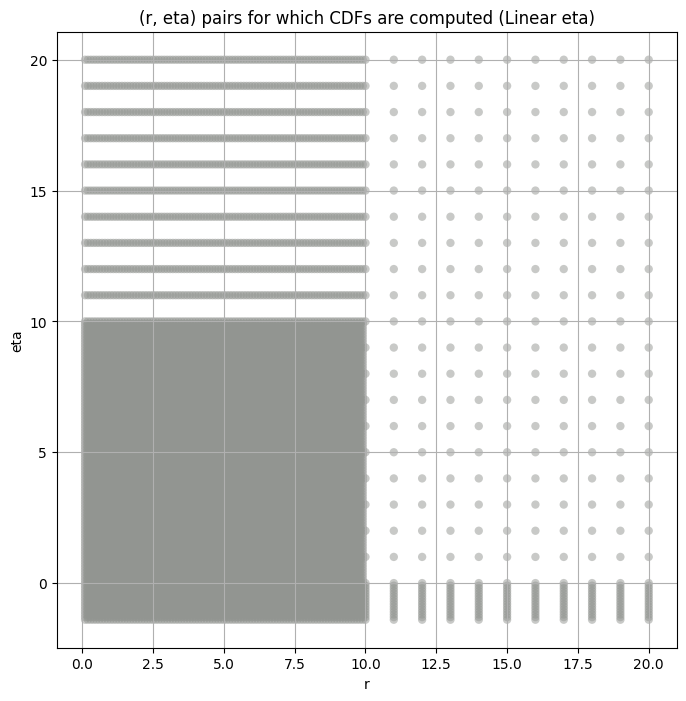

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 30


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,3.045431e+14,2.487557e+14,3.723887e+14,6.924574,2.464588,11.612601,720.0
5,7.378003e+14,6.583447e+14,8.222332e+14,16.583754,13.942364,19.255954,7200.0
8,1.589118e+14,1.382152e+14,1.825356e+14,27.638625,18.410191,41.788233,13680.0
11,1.331968e+13,1.047198e+13,1.831032e+13,131.956672,9.279535,327.704406,28080.0
14,3.351638e+14,3.051447e+14,3.680087e+14,11.289211,8.023763,15.603495,56160.0
17,4.358627e+14,4.119868e+14,4.620584e+14,2.983397,1.971252,6.272248,450720.0
20,2.468744e+13,2.310901e+13,2.647411e+13,4.895737,2.619916,11.424115,901440.0
23,4.719306e+12,4.387672e+12,5.331824e+12,11.471690,2.397953,66.410982,7211520.0
26,2.697279e+11,2.537490e+11,2.868330e+11,3.709730,2.595050,6.189963,3605760.0


## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,3.045431e+14,3.045431e+14,1.847886e+14,1.523770e+14,1.282977e+14,1.108788e+14,8.474535e+13,6.511215e+13,4.936709e+13,3.756553e+13,2.821287e+13,7.987203e+12
5,7.378003e+14,7.378003e+14,6.008423e+14,5.270331e+14,4.754088e+14,4.323105e+14,3.658306e+14,3.155561e+14,2.780755e+14,2.473795e+14,2.230507e+14,1.735999e+14
8,1.589118e+14,1.589118e+14,1.322593e+14,1.187684e+14,1.095624e+14,1.022259e+14,9.053884e+13,8.156696e+13,7.442379e+13,6.862287e+13,6.390835e+13,5.404822e+13
11,1.331968e+13,1.331968e+13,1.020575e+13,9.768501e+12,9.482872e+12,9.255875e+12,8.874170e+12,8.565451e+12,8.313057e+12,8.100293e+12,7.917088e+12,7.474923e+12
14,3.351638e+14,3.351638e+14,3.208023e+14,3.128669e+14,3.063974e+14,3.008328e+14,2.911185e+14,2.827801e+14,2.752442e+14,2.683517e+14,2.620138e+14,2.454094e+14
17,4.358627e+14,4.358627e+14,4.271373e+14,4.217593e+14,4.171295e+14,4.130359e+14,4.058245e+14,3.995437e+14,3.938702e+14,3.886259e+14,3.837468e+14,3.706521e+14
20,2.468744e+13,2.468744e+13,2.393368e+13,2.353645e+13,2.321997e+13,2.294788e+13,2.248351e+13,2.208408e+13,2.173004e+13,2.140961e+13,2.111392e+13,2.033129e+13
23,4.719306e+12,4.719306e+12,4.540016e+12,4.469951e+12,4.413171e+12,4.363838e+12,4.278704e+12,4.205297e+12,4.139743e+12,4.080083e+12,4.024966e+12,3.879509e+12
26,2.697279e+11,2.697279e+11,2.636978e+11,2.598432e+11,2.566106e+11,2.537459e+11,2.487364e+11,2.443568e+11,2.404278e+11,2.368254e+11,2.334804e+11,2.245850e+11


####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.012723210642710148 304543067915136.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.028953995993303505 184788559201807.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.0498607517269829 152377030498135.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.06773365307571866 128297738824228.66


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.08243248435216499 110878810274506.77


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.11301176800764268 84745354298435.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.14303317802064236 65112147414808.695


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.17351443638508257 49367090639117.62


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.201318089773876 37565526935017.17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.22715492178039964 28212870937550.734


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.31417613887990514 7987202799996.98
Number of samples: 1440, Without approximation : 720.0


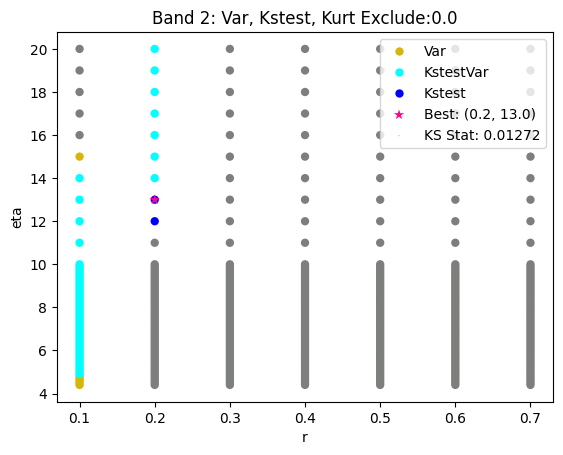

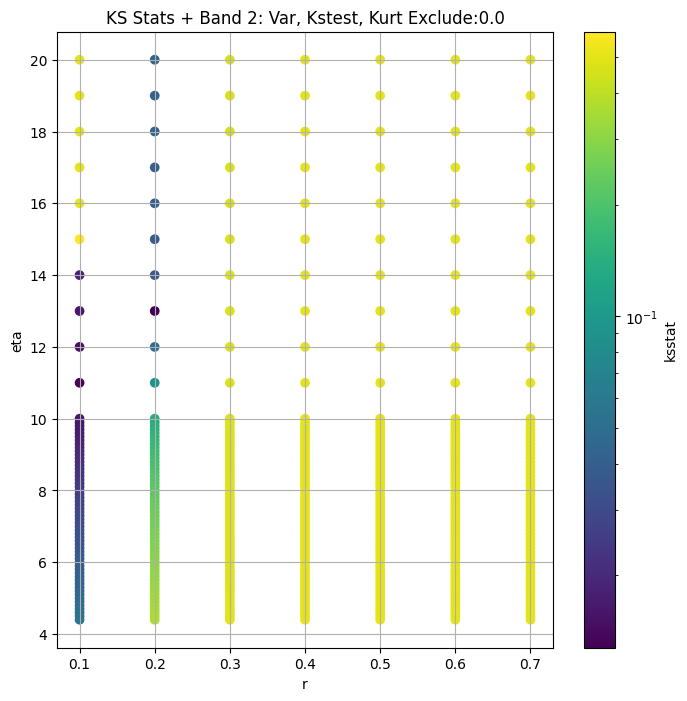

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.02354979749745112 737800296536782.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.019437481183873118 600842312056580.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.01647194124645801 527033096955810.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.013593998412736785 475408775457188.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.012450673410083102 432310523478585.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.015520888328401091 365830552272273.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.018396908429473613 315556054606353.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.021157333174623094 278075490145870.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.024318749932657147 247379532076076.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.027844846234382326 223050680925335.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.03813074390691522 173599924500996.34
Number of samples: 14400, Without approximation : 7200.0


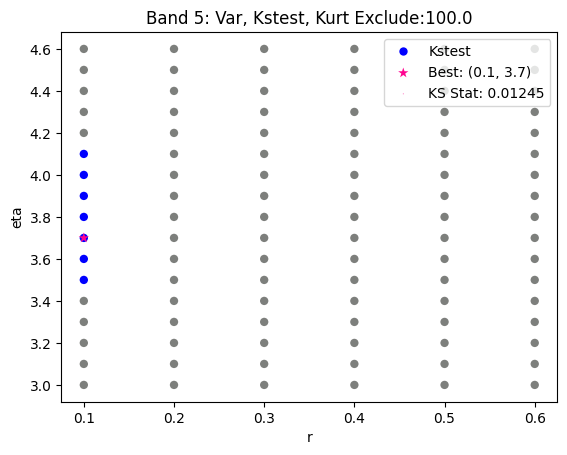

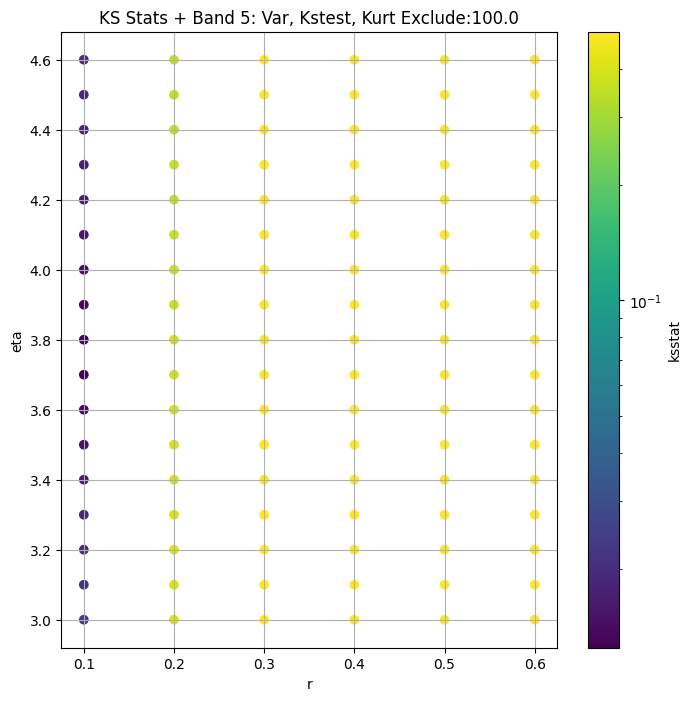

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.018161901081074627 158911782157216.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.018161901081074627 132259299367872.52


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.018161901081074627 118768393767734.31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.01652018910066777 109562353334152.36


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.014635968196093585 102225909667799.98


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.011257253773912512 90538843047839.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.010494361637381378 81566956206532.17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.01212241970886478 74423794698240.14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.014180565967514713 68622868608653.93


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.016001314965119362 63908354666363.81


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.020699064105656695 54048223044115.35
Number of samples: 27360, Without approximation : 13680.0


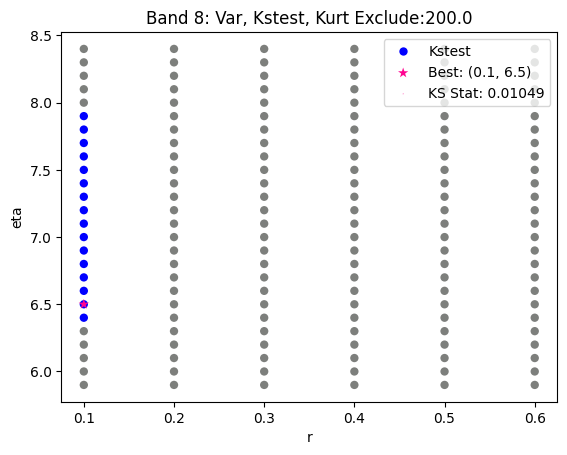

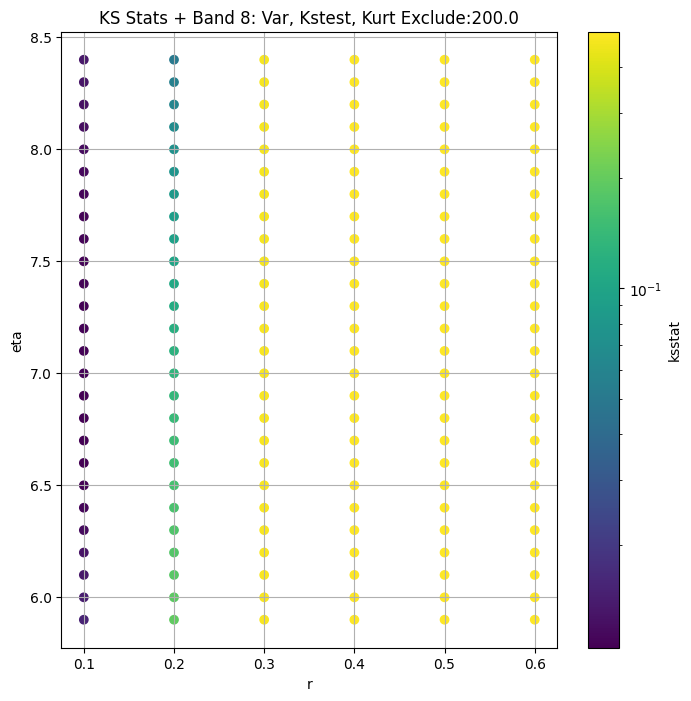

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.008600645138588825 13319676360562.291


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.0076768944709529885 10205748336743.559


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.0062230130506044645 9768500929715.219


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.005304493255787759 9482872171258.566


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.004303837551837886 9255875010600.303


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.003952767662328882 8874170392740.953


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.004646089343252946 8565450925927.622


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.005129645074373973 8313056748095.715


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.006205366730892559 8100292997477.126


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.007351259535053001 7917087773733.676


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.01113468751912261 7474922712944.471
Number of samples: 56160, Without approximation : 28080.0


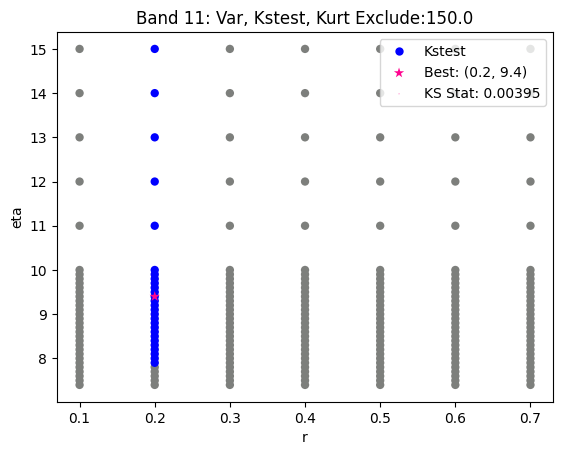

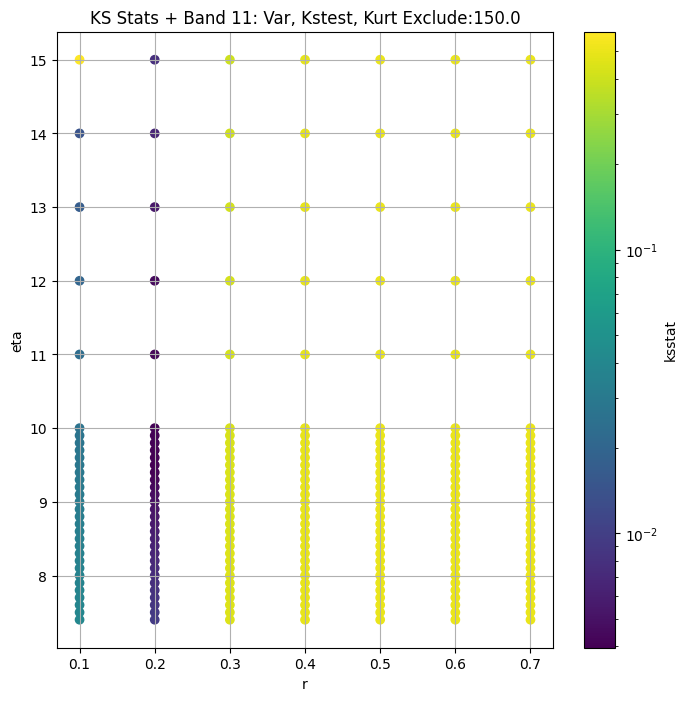

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.023865807599413313 335163805613060.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.02605159969215884 320802280844092.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.02565235843571778 312866868833246.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.02611547989780541 306397386176513.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.02700755698840053 300832760564272.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.026899463791528966 291118514552561.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.028100004384064903 282780145841473.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.028657407884501662 275244220004484.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.028896284079920606 268351653210710.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.030067290244097197 262013789087056.62


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.031137198282524703 245409365851193.44
Number of samples: 100000, Without approximation : 56160.0


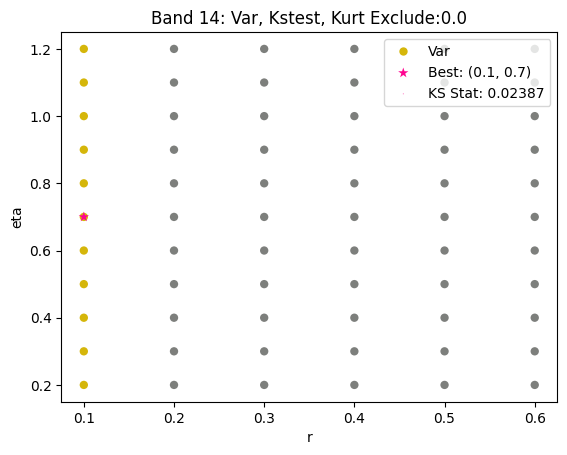

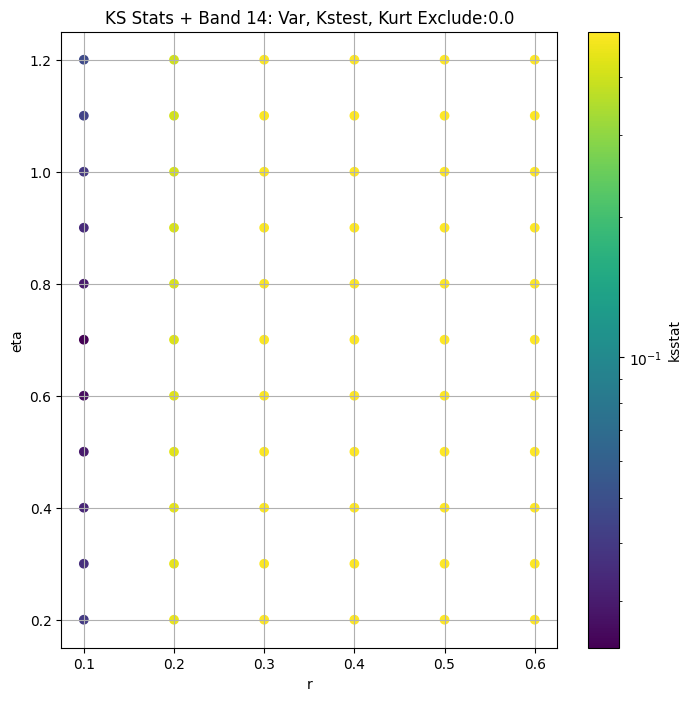

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.004977833662930128 435862654126958.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.006602277415685864 427137307842056.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.0059648692738375475 421759287677429.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.006681350258457369 417129532987659.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.007024276640416938 413035852805397.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.007596624639195276 405824494379571.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.007857757943980206 399543707855868.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.008207175097831435 393870246516939.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.009303696771660902 388625931075262.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.0103473253776947 383746822612615.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.013290914425152137 370652073881517.56
Number of samples: 100000, Without approximation : 450720.0


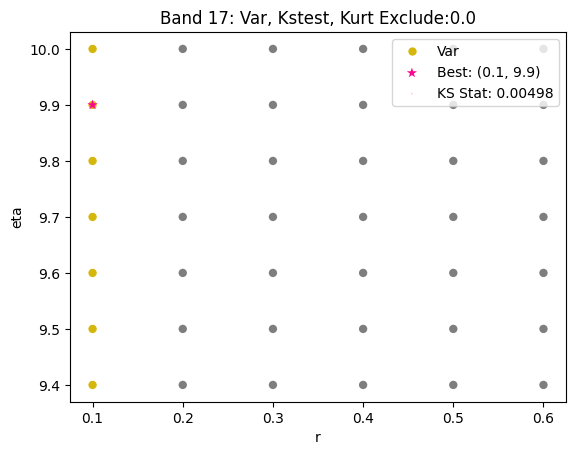

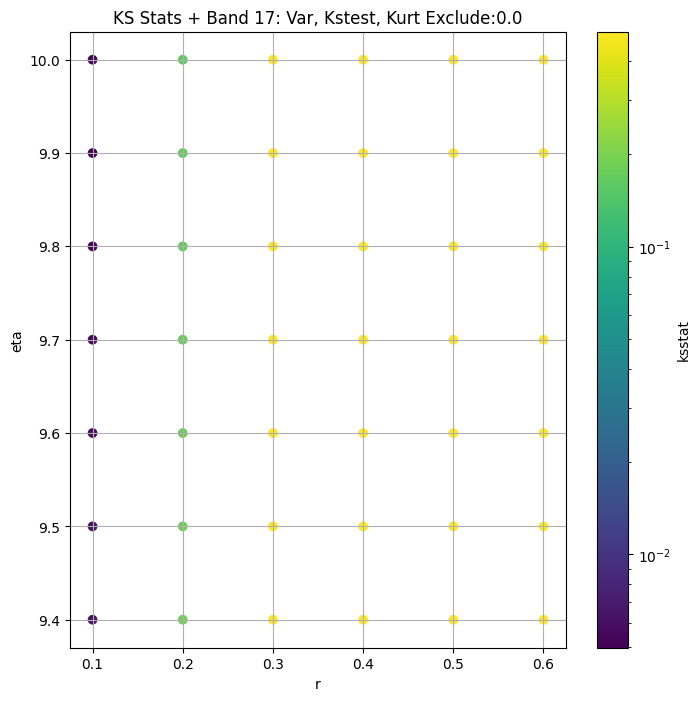

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.002351745568290098 24687443314136.125


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.0010473444892195038 23933681686053.926


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.0014132486274478495 23536446024775.184


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.0015678373219297666 23219971887545.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.001961301638195658 22947882484078.57


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.002938705545076338 22483507233394.562


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.0038140475917343777 22084080432589.445


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.004491143423231925 21730041949578.05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.005254331117320113 21409609119299.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.006012944176122581 21113922466049.367


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.008173711895614041 20331288469928.066
Number of samples: 100000, Without approximation : 901440.0


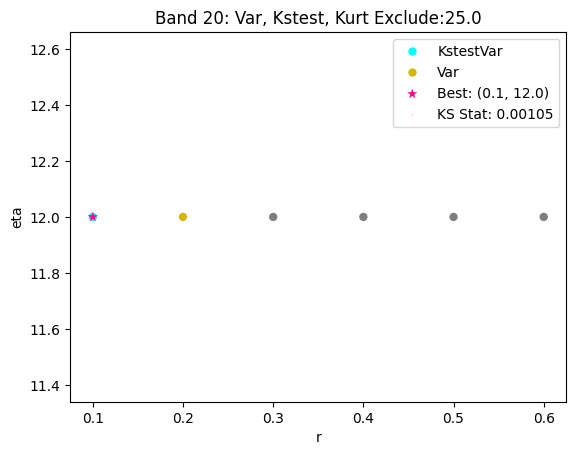

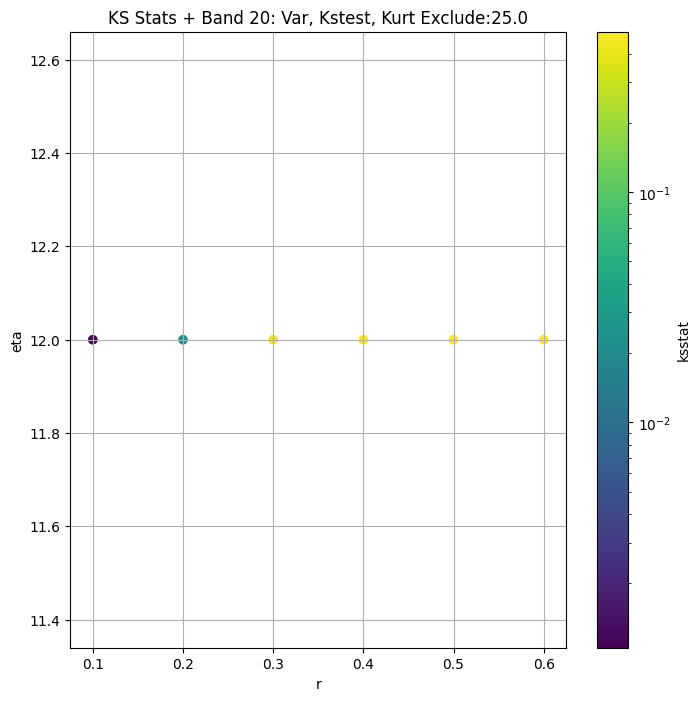

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.0021487512472634362 4719305909370.693


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.0011379239515185713 4540016161856.014


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.0011086881233599143 4469950663621.995


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.0014673585639436264 4413171324855.296


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0018536831639529919 4363838131149.2705


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.0027951804743062553 4278704367216.5996


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.0036976340640439975 4205297115791.6665


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.004537118901021431 4139743207572.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.005329585128638889 4080082789508.902


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.006088062184665351 4024966482879.678


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.008215448239020422 3879508603340.232
Number of samples: 100000, Without approximation : 7211520.0


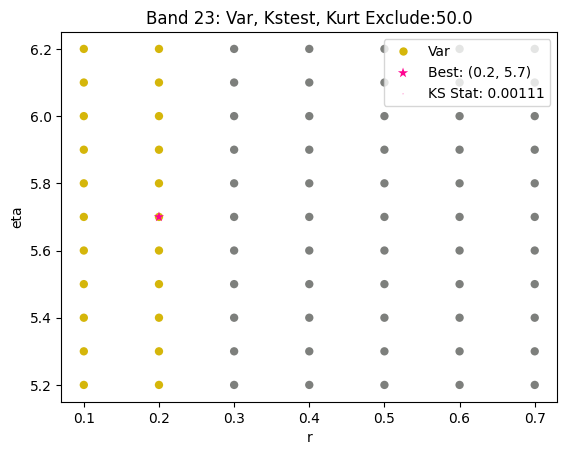

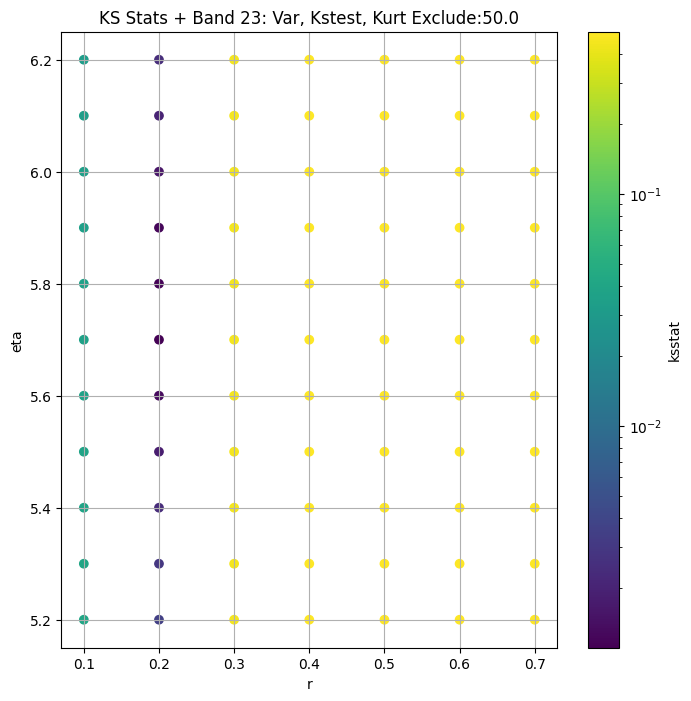

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.0006349102312060428 269727935605.29977


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.0013431879114666131 263697809842.55557


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.0020083004565283266 259843160421.68677


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.0025805902504050585 256610588741.78604


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.0030990901363516996 253745935181.30774


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.004040948121862016 248736437256.19803


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.0049004528959081944 244356846885.48322


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.005705175467621219 240427849947.8962


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.006473009098853913 236825364894.63345


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.007216041506593773 233480354965.78336


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.009292301531913273 224585029995.02344
Number of samples: 100000, Without approximation : 3605760.0


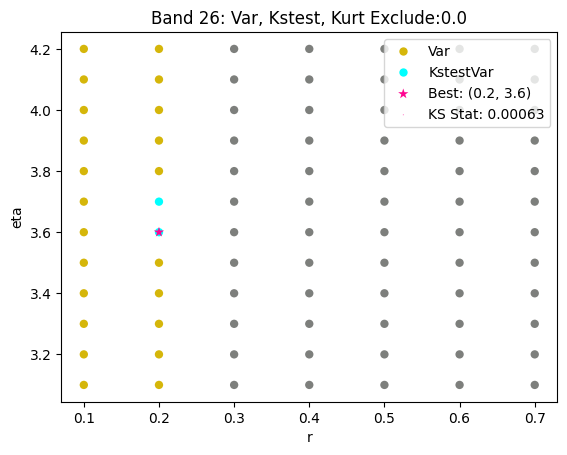

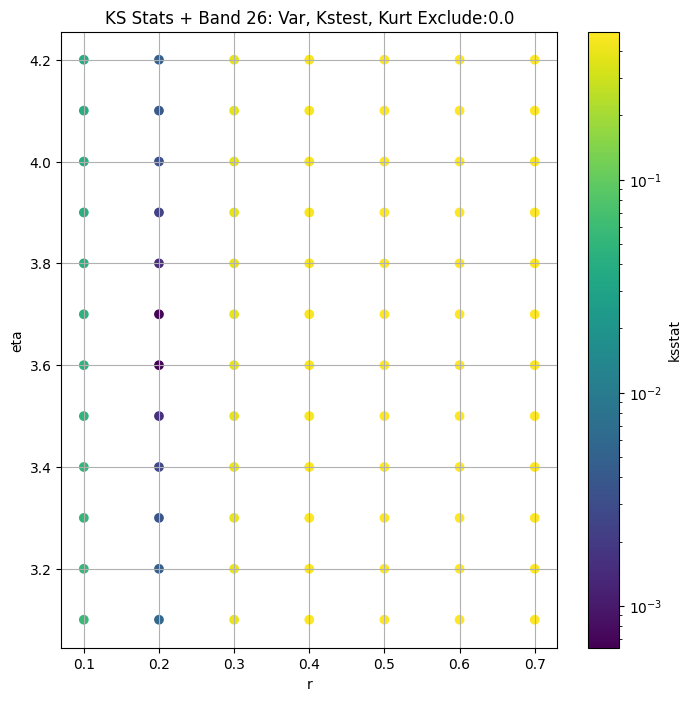

####
Band  30


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 0 0.0017224698746170497 26470233914.13792


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 25 0.0018463846610050974 25645447731.82785


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 50 0.002233934032991658 25125796652.019436


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 75 0.002595706161083622 24694736694.299503


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 100 0.0031146816450013937 24316581409.433243


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 150 0.004065485567863399 23660544531.0132


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 200 0.004954989127757964 23094076965.909283


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 250 0.005797225064137011 22589856875.2851


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 300 0.006593106528948615 22132814481.244938


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 350 0.0073553201347147865 21712941589.687634


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 500 0.009507690835775573 20617150148.327564
Number of samples: 100000, Without approximation : 7211520.0


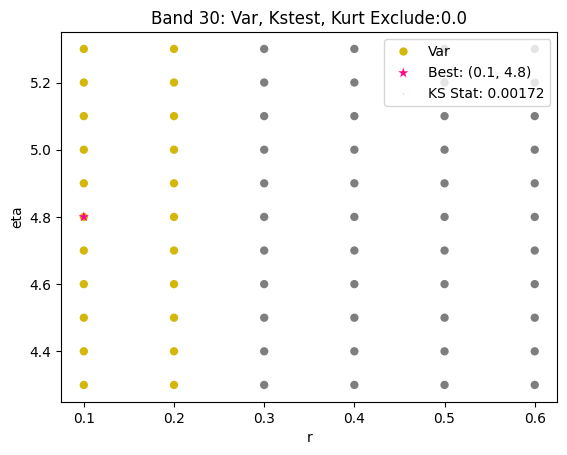

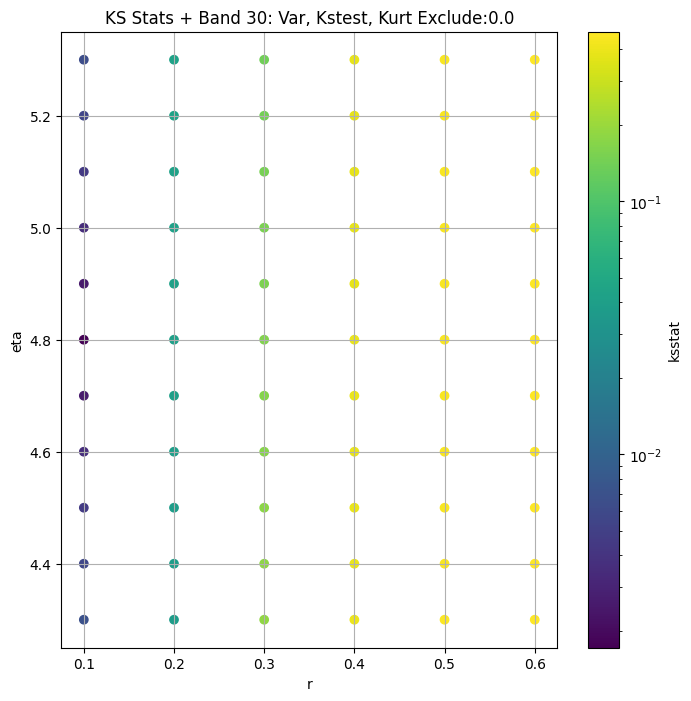

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,3.045431e+14,2.487557e+14,3.723887e+14,6.924574,2.464588,11.612601,720.0,0.012723,0.2,13.0,1.000000e+05,0.0,3.045431e+14,0.050376
5,7.378003e+14,6.583447e+14,8.222332e+14,16.583754,13.942364,19.255954,7200.0,0.012451,0.1,3.7,1.321101e-03,100.0,4.323105e+14,0.015982
8,1.589118e+14,1.382152e+14,1.825356e+14,27.638625,18.410191,41.788233,13680.0,0.010494,0.1,6.5,4.420371e-06,200.0,8.156696e+13,0.011599
11,1.331968e+13,1.047198e+13,1.831032e+13,131.956672,9.279535,327.704406,28080.0,0.003953,0.2,9.4,1.543711e+04,150.0,8.874170e+12,0.008099
14,3.351638e+14,3.051447e+14,3.680087e+14,11.289211,8.023763,15.603495,56160.0,0.023866,0.1,0.7,2.082472e+00,0.0,3.351638e+14,0.005728
17,4.358627e+14,4.119868e+14,4.620584e+14,2.983397,1.971252,6.272248,450720.0,0.004978,0.1,9.9,8.006498e-07,0.0,4.358627e+14,0.002023
20,2.468744e+13,2.310901e+13,2.647411e+13,4.895737,2.619916,11.424115,901440.0,0.001047,0.1,12.0,8.593862e-09,25.0,2.393368e+13,0.001430
23,4.719306e+12,4.387672e+12,5.331824e+12,11.471690,2.397953,66.410982,7211520.0,0.001109,0.2,5.7,5.660963e+04,50.0,4.469951e+12,0.000506
26,2.697279e+11,2.537490e+11,2.868330e+11,3.709730,2.595050,6.189963,3605760.0,0.000635,0.2,3.6,1.726396e+04,0.0,2.697279e+11,0.000715


In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.08903741852689342, var: 110878810274506.77


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.07297107642280376, var: 128297738824228.66


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.05440592745418252, var: 152377030498135.94


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.03425084747049356, var: 184788559201807.4


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.012723210642710148, var: 304543067915136.06
Number of samples: 1440, Without approximation : 720.0


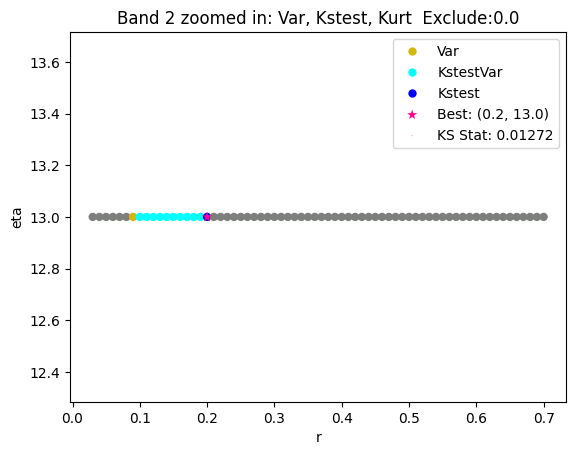

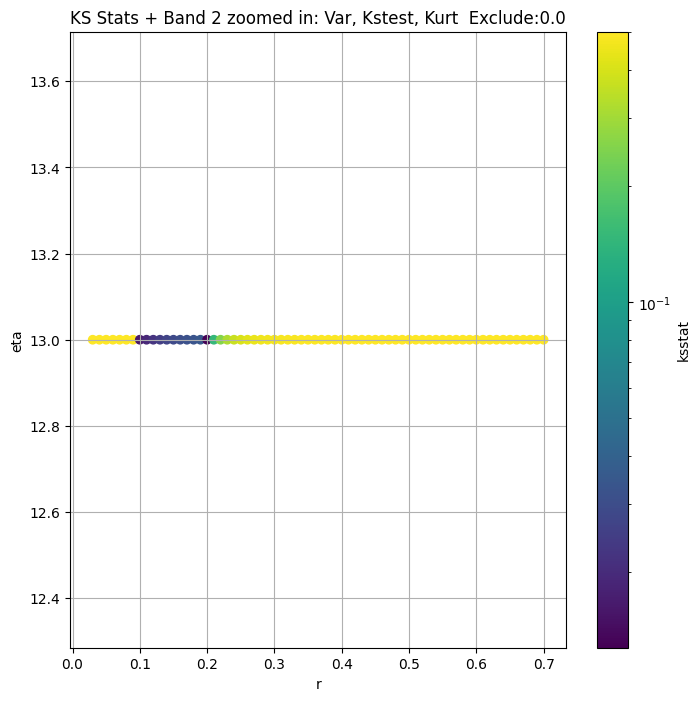

Band 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 100 = 200, ksstat: 0.01837472791057064, var: 315556054606353.3


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 75 = 175, ksstat: 0.01693467712906683, var: 339184939148807.56


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 50 = 150, ksstat: 0.015496541835489097, var: 365830552272273.44


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 25 = 125, ksstat: 0.014038378088550352, var: 395802938165522.94


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 0 = 100, ksstat: 0.012450673410083102, var: 432310523478585.25


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -25 = 75, ksstat: 0.013863735320259973, var: 475408775457188.06


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -50 = 50, ksstat: 0.01588469109157775, var: 527033096955810.6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -75 = 25, ksstat: 0.017690465392728505, var: 600842312056580.1


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -100 = 0, ksstat: 0.017690465392728505, var: 737800296536782.9
Number of samples: 14400, Without approximation : 7200.0


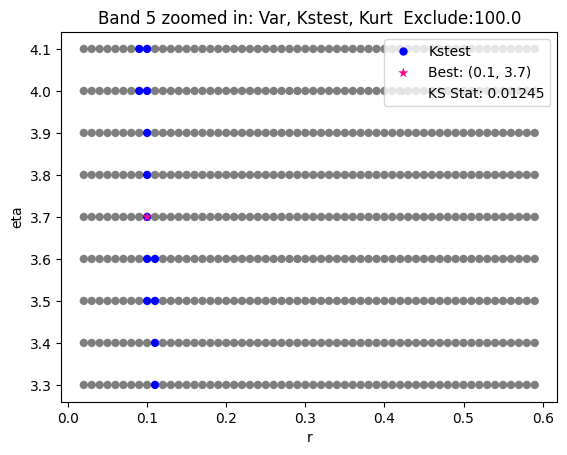

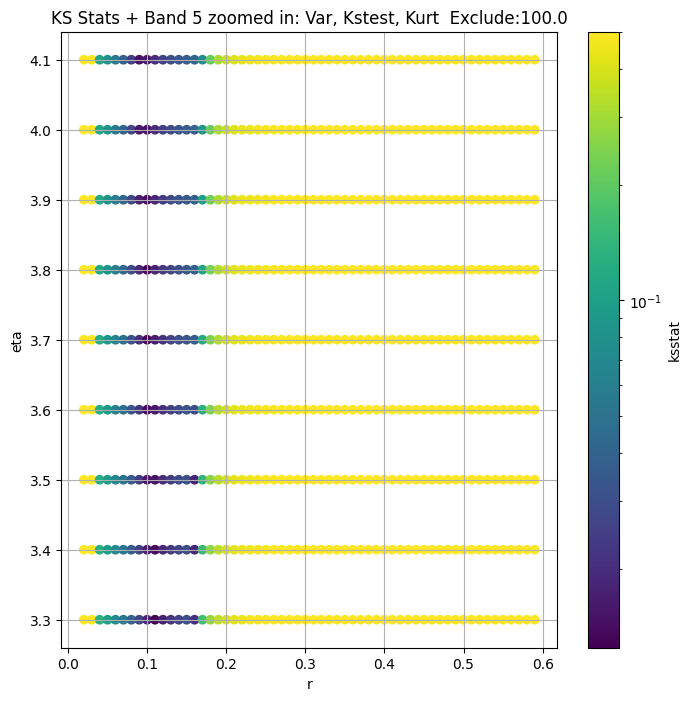

Band 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 100 = 300, ksstat: 0.014184859074875655, var: 68622868608653.93


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 75 = 275, ksstat: 0.013153082959538922, var: 71361956166854.88


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 50 = 250, ksstat: 0.012086013609522328, var: 74423794698240.14


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 25 = 225, ksstat: 0.011248513161517315, var: 77778749802064.38


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 0 = 200, ksstat: 0.010494361637381378, var: 81566956206532.17


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -25 = 175, ksstat: 0.009642781306741068, var: 85822841021011.22


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -50 = 150, ksstat: 0.01109761424184176, var: 90538843047839.1


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -75 = 125, ksstat: 0.012619260243028285, var: 95932905759706.72


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -100 = 100, ksstat: 0.014319421681878386, var: 102225909667799.98
Number of samples: 27360, Without approximation : 13680.0


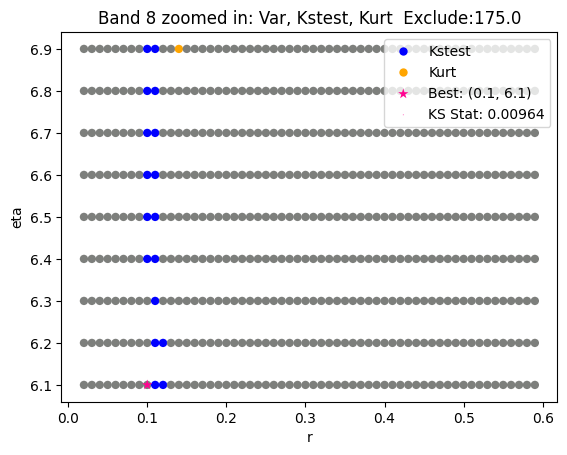

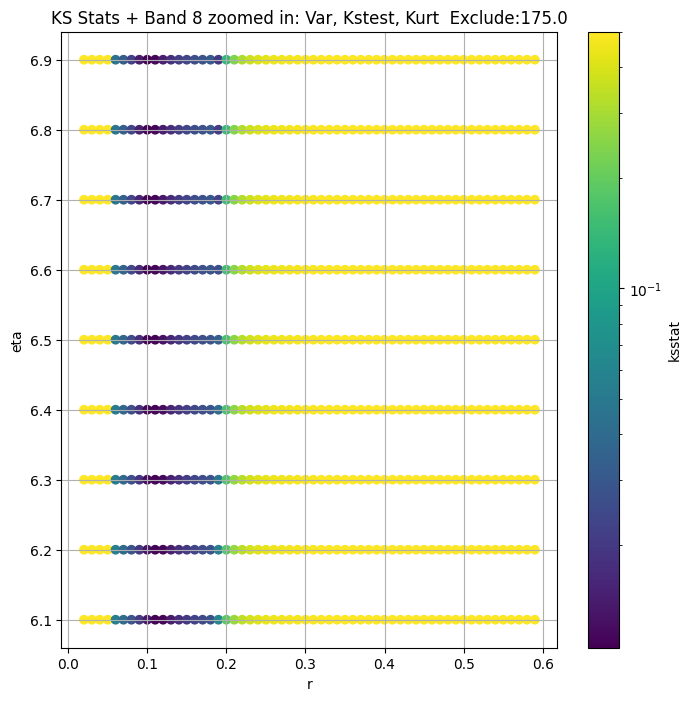

Band 11


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 100 = 250, ksstat: 0.0075904142652257756, var: 8313056748095.715


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 75 = 225, ksstat: 0.006103445921873396, var: 8434078315852.126


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 50 = 200, ksstat: 0.004785057465670484, var: 8565450925927.622


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 25 = 175, ksstat: 0.004272919326972213, var: 8710353731242.665


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 0 = 150, ksstat: 0.003952767662328882, var: 8874170392740.953


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -25 = 125, ksstat: 0.0036224395660898745, var: 9055232820498.473


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -50 = 100, ksstat: 0.004200778830155086, var: 9255875010600.303


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -75 = 75, ksstat: 0.005161991775863295, var: 9482872171258.566


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -100 = 50, ksstat: 0.0062608169759124505, var: 9768500929715.219
Number of samples: 56160, Without approximation : 28080.0


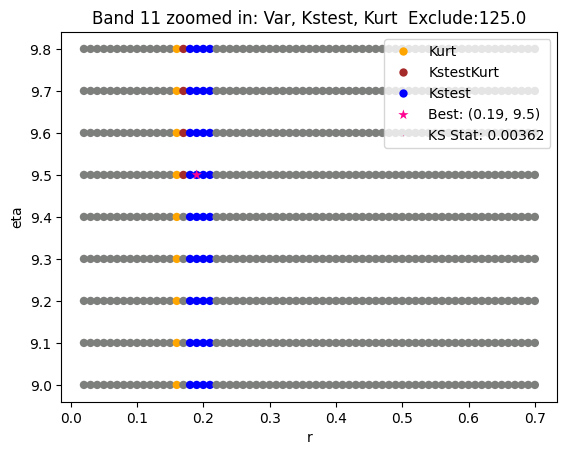

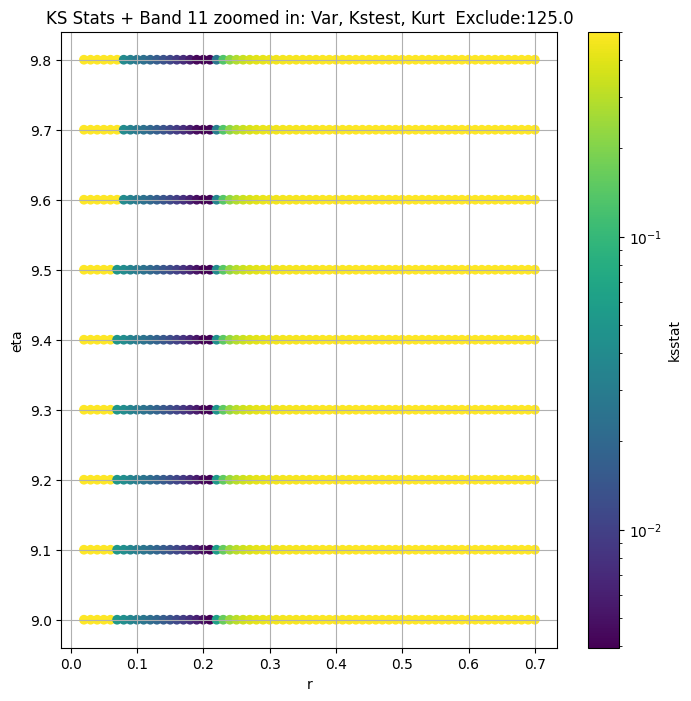

Band 14


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 14, 0.0 + 100 = 100, ksstat: 0.02566157449839651, var: 300832760564272.94


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 14, 0.0 + 75 = 75, ksstat: 0.02494953556589241, var: 306397386176513.2


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 14, 0.0 + 50 = 50, ksstat: 0.02565235843571778, var: 312866868833246.2


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 14, 0.0 + 25 = 25, ksstat: 0.025012419092299162, var: 320802280844092.94


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 14, 0.0 + 0 = 0, ksstat: 0.02317593867356793, var: 335163805613060.75
Number of samples: 100000, Without approximation : 56160.0


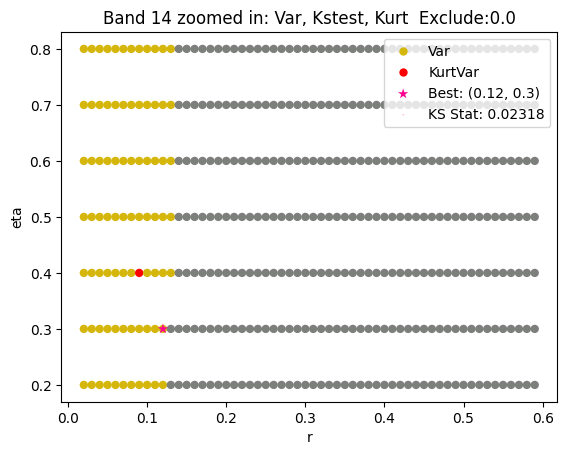

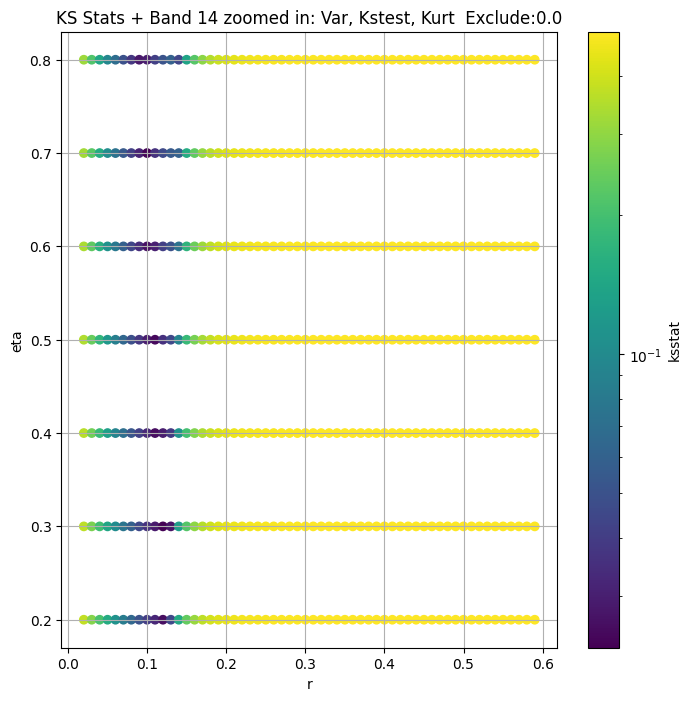

Band 17


  0%|          | 0/347 [00:00<?, ?it/s]

Finding Minimum after computing 347 CDFs
band 17, 0.0 + 100 = 100, ksstat: 0.006430417066072058, var: 413035852805397.7


  0%|          | 0/347 [00:00<?, ?it/s]

Finding Minimum after computing 347 CDFs
band 17, 0.0 + 75 = 75, ksstat: 0.006322604231504714, var: 417129532987659.2


  0%|          | 0/347 [00:00<?, ?it/s]

Finding Minimum after computing 347 CDFs
band 17, 0.0 + 50 = 50, ksstat: 0.005829837995645626, var: 421759287677429.1


  0%|          | 0/347 [00:00<?, ?it/s]

Finding Minimum after computing 347 CDFs
band 17, 0.0 + 25 = 25, ksstat: 0.005696267773320218, var: 427137307842056.06


  0%|          | 0/347 [00:00<?, ?it/s]

Finding Minimum after computing 347 CDFs
band 17, 0.0 + 0 = 0, ksstat: 0.004977833662930128, var: 435862654126958.7
Number of samples: 100000, Without approximation : 450720.0


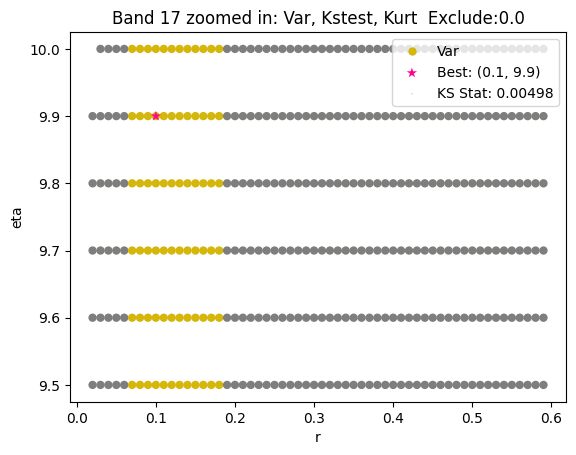

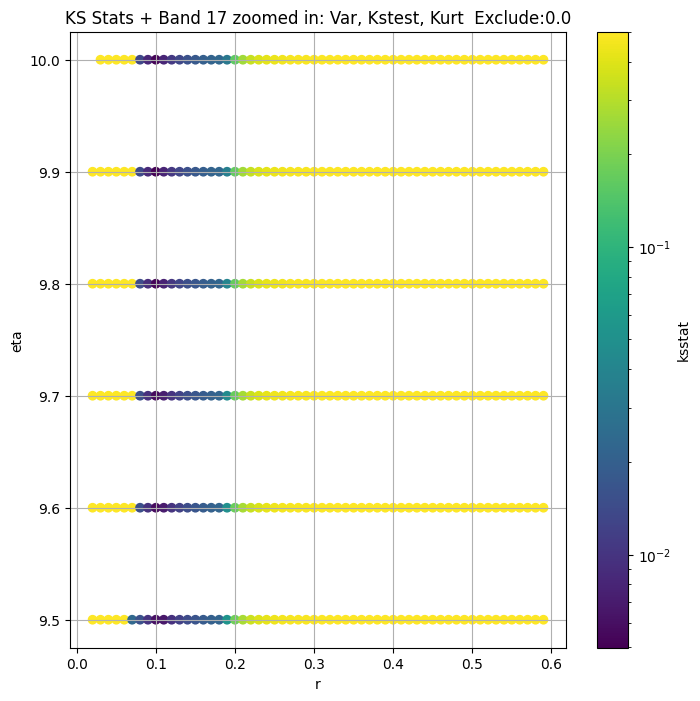

Band 20


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 25.0 + 100 = 125, ksstat: 0.0024370117771568903, var: 22705336543845.824


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 25.0 + 75 = 100, ksstat: 0.00201853585348509, var: 22947882484078.57


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 25.0 + 50 = 75, ksstat: 0.0016277393399772022, var: 23219971887545.75


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 25.0 + 25 = 50, ksstat: 0.0019609087109488943, var: 23536446024775.184


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 25.0 + 0 = 25, ksstat: 0.0010473444892195038, var: 23933681686053.926


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 25.0 + -25 = 0, ksstat: 0.0024081791911273465, var: 24687443314136.125
Number of samples: 100000, Without approximation : 901440.0


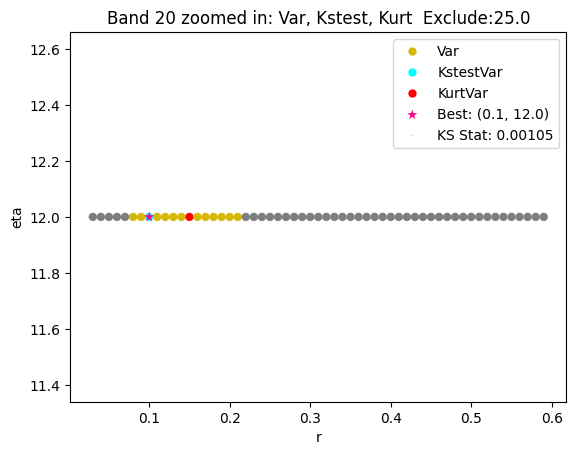

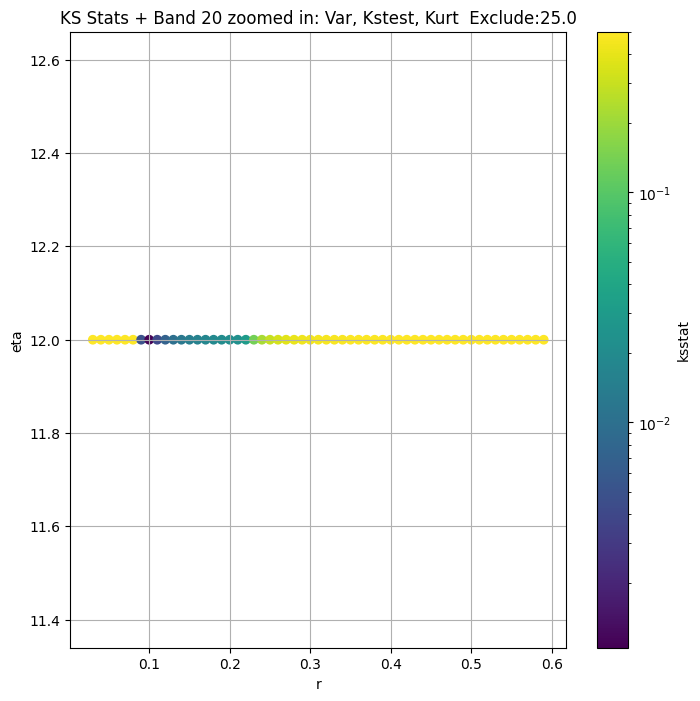

Band 23


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + 100 = 150, ksstat: 0.002868159575707574, var: 4278704367216.5996


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + 75 = 125, ksstat: 0.0023141094288415542, var: 4319463099624.986


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + 50 = 100, ksstat: 0.0018536831639529919, var: 4363838131149.2705


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + 25 = 75, ksstat: 0.0014673585639436264, var: 4413171324855.296


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + 0 = 50, ksstat: 0.0011086881233599143, var: 4469950663621.995


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + -25 = 25, ksstat: 0.0011379239515185713, var: 4540016161856.014


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + -50 = 0, ksstat: 0.0025351076008645057, var: 4719305909370.693
Number of samples: 100000, Without approximation : 7211520.0


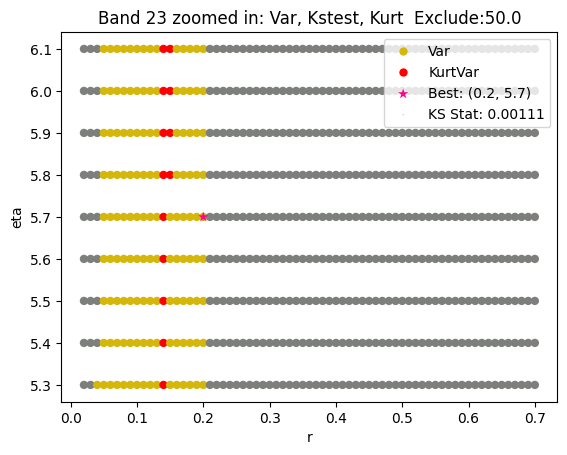

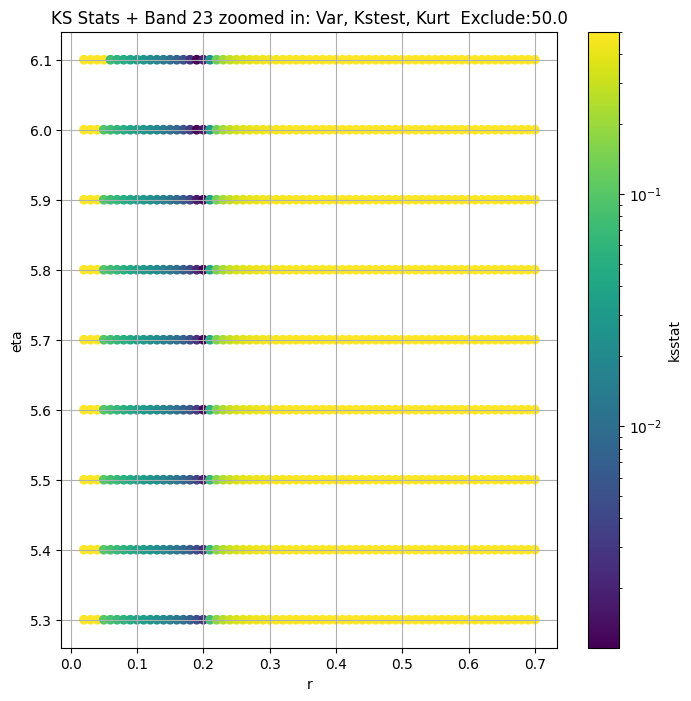

Band 26


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 26, 0.0 + 100 = 100, ksstat: 0.003042200186349882, var: 253745935181.30774


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 26, 0.0 + 75 = 75, ksstat: 0.0025197606605455725, var: 256610588741.78604


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 26, 0.0 + 50 = 50, ksstat: 0.0019777754327494276, var: 259843160421.68677


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 26, 0.0 + 25 = 25, ksstat: 0.0013125925071412817, var: 263697809842.55557


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 26, 0.0 + 0 = 0, ksstat: 0.0003907879101555656, var: 269727935605.29977
Number of samples: 100000, Without approximation : 3605760.0


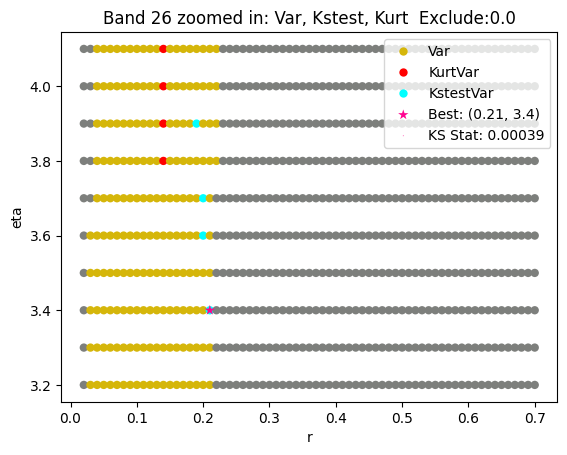

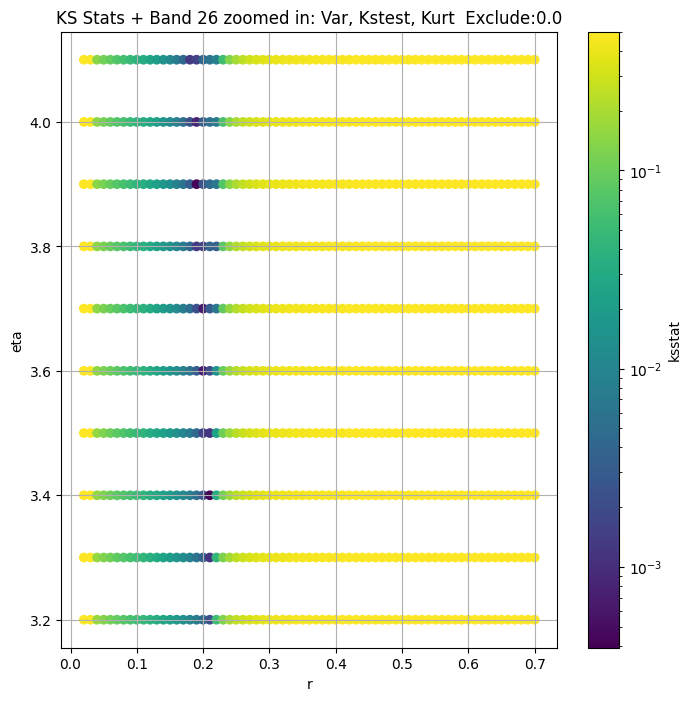

Band 30


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 100 = 100, ksstat: 0.003506957233226901, var: 24316581409.433243


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 75 = 75, ksstat: 0.003027602616882126, var: 24694736694.299503


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 50 = 50, ksstat: 0.0024458886994606355, var: 25125796652.019436


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 25 = 25, ksstat: 0.0018137934963164473, var: 25645447731.82785


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 0 = 0, ksstat: 0.0017224698746170497, var: 26470233914.13792
Number of samples: 100000, Without approximation : 7211520.0


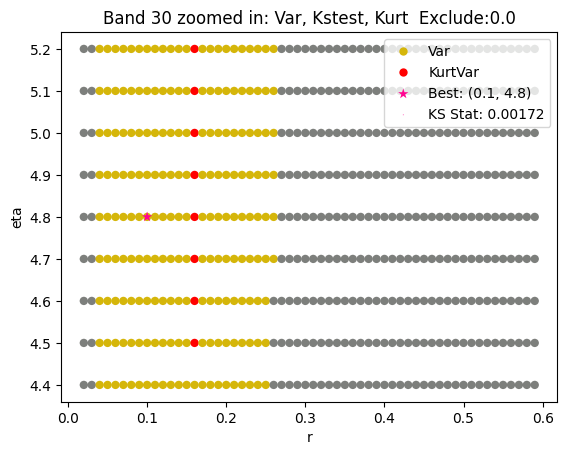

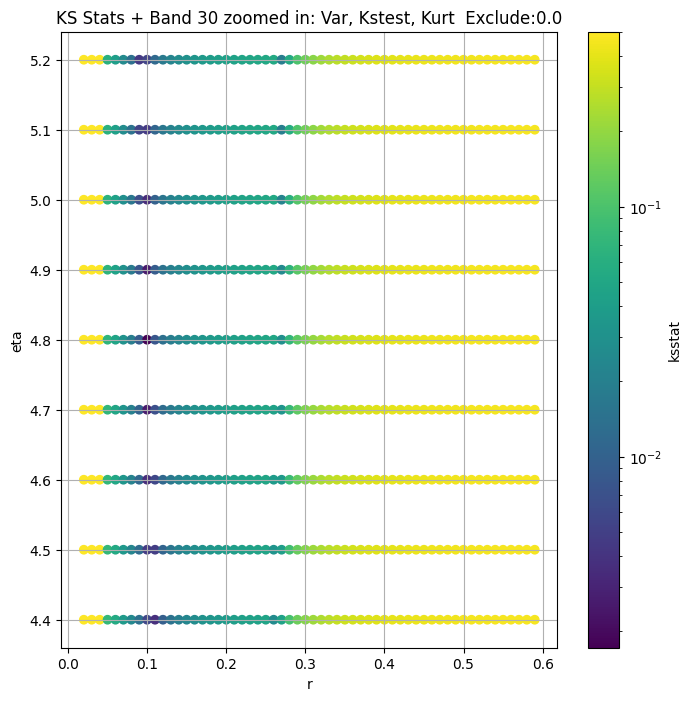

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,3.045431e+14,2.487557e+14,3.723887e+14,6.924574,2.464588,11.612601,720.0,0.012723,0.2,13.0,1.000000e+05,0.0,3.045431e+14,0.050376,0.012723,0.20,13.0,1.000000e+05,0.0,11673
5,7.378003e+14,6.583447e+14,8.222332e+14,16.583754,13.942364,19.255954,7200.0,0.012451,0.1,3.7,1.321101e-03,100.0,4.323105e+14,0.015982,0.012451,0.10,3.7,1.321101e-03,100.0,12150
8,1.589118e+14,1.382152e+14,1.825356e+14,27.638625,18.410191,41.788233,13680.0,0.010494,0.1,6.5,4.420371e-06,200.0,8.582284e+13,0.011599,0.009643,0.10,6.1,7.558084e-06,175.0,20520
11,1.331968e+13,1.047198e+13,1.831032e+13,131.956672,9.279535,327.704406,28080.0,0.003953,0.2,9.4,1.543711e+04,150.0,9.055233e+12,0.008099,0.003622,0.19,9.5,3.961983e+03,125.0,142155
14,3.351638e+14,3.051447e+14,3.680087e+14,11.289211,8.023763,15.603495,56160.0,0.023866,0.1,0.7,2.082472e+00,0.0,3.351638e+14,0.005728,0.023176,0.12,0.3,9.185283e+03,0.0,3510
17,4.358627e+14,4.119868e+14,4.620584e+14,2.983397,1.971252,6.272248,450720.0,0.004978,0.1,9.9,8.006498e-07,0.0,4.358627e+14,0.002023,0.004978,0.10,9.9,8.006498e-07,0.0,71304
20,2.468744e+13,2.310901e+13,2.647411e+13,4.895737,2.619916,11.424115,901440.0,0.001047,0.1,12.0,8.593862e-09,25.0,2.393368e+13,0.001430,0.001047,0.10,12.0,8.593862e-09,25.0,1711327
23,4.719306e+12,4.387672e+12,5.331824e+12,11.471690,2.397953,66.410982,7211520.0,0.001109,0.2,5.7,5.660963e+04,50.0,4.469951e+12,0.000506,0.001109,0.20,5.7,5.660963e+04,50.0,1521180
26,2.697279e+11,2.537490e+11,2.868330e+11,3.709730,2.595050,6.189963,3605760.0,0.000635,0.2,3.6,1.726396e+04,0.0,2.697279e+11,0.000715,0.000391,0.21,3.4,5.745964e+04,0.0,12169440


In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

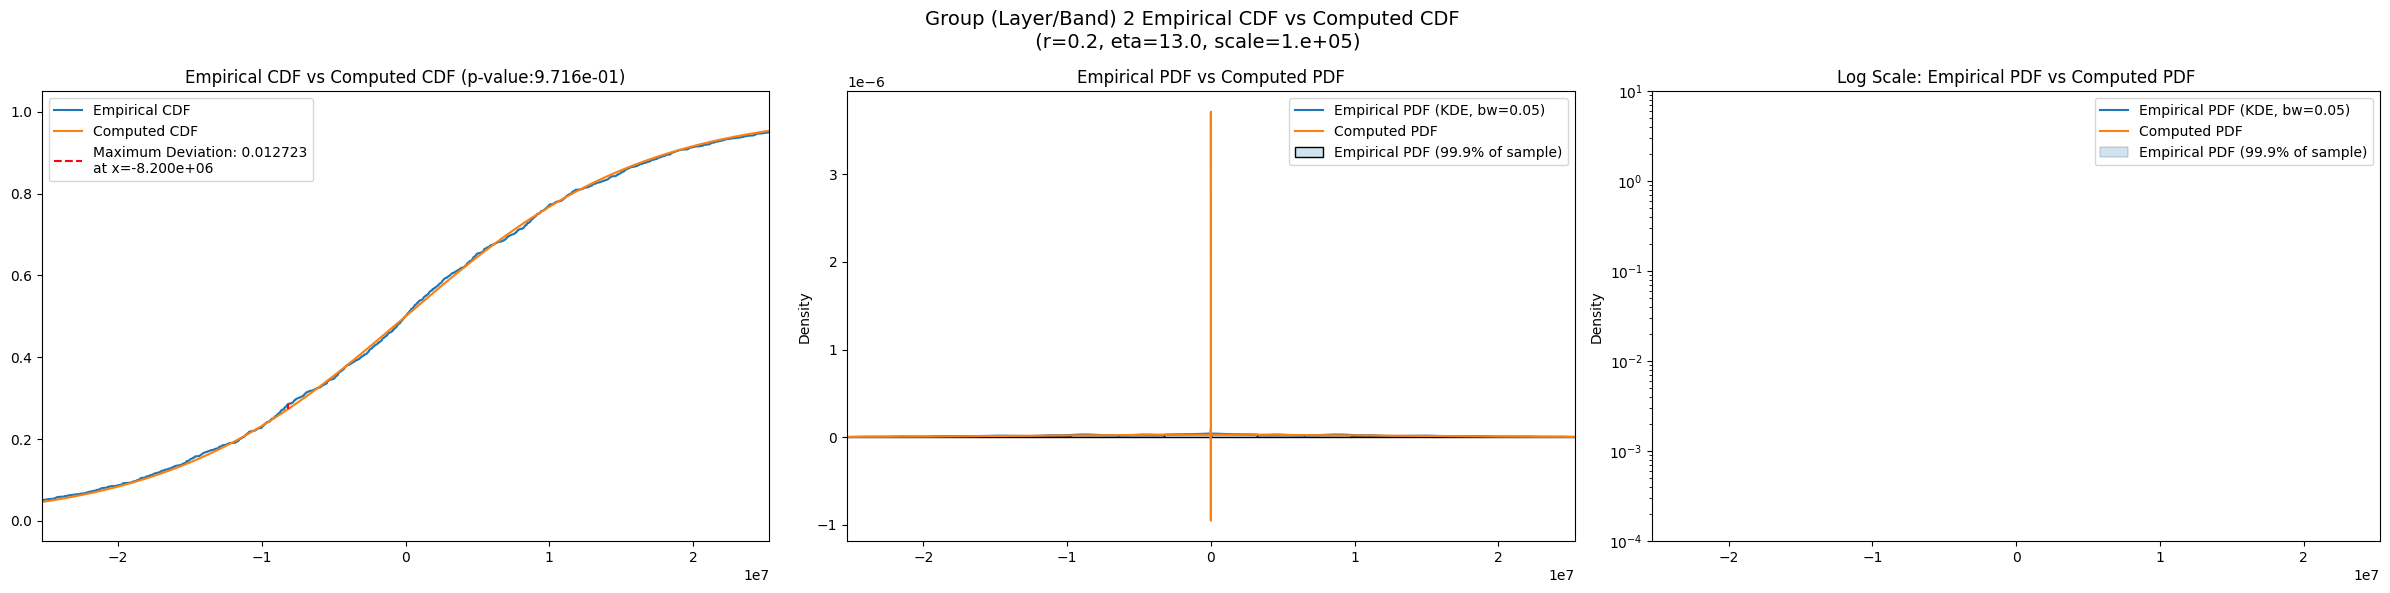

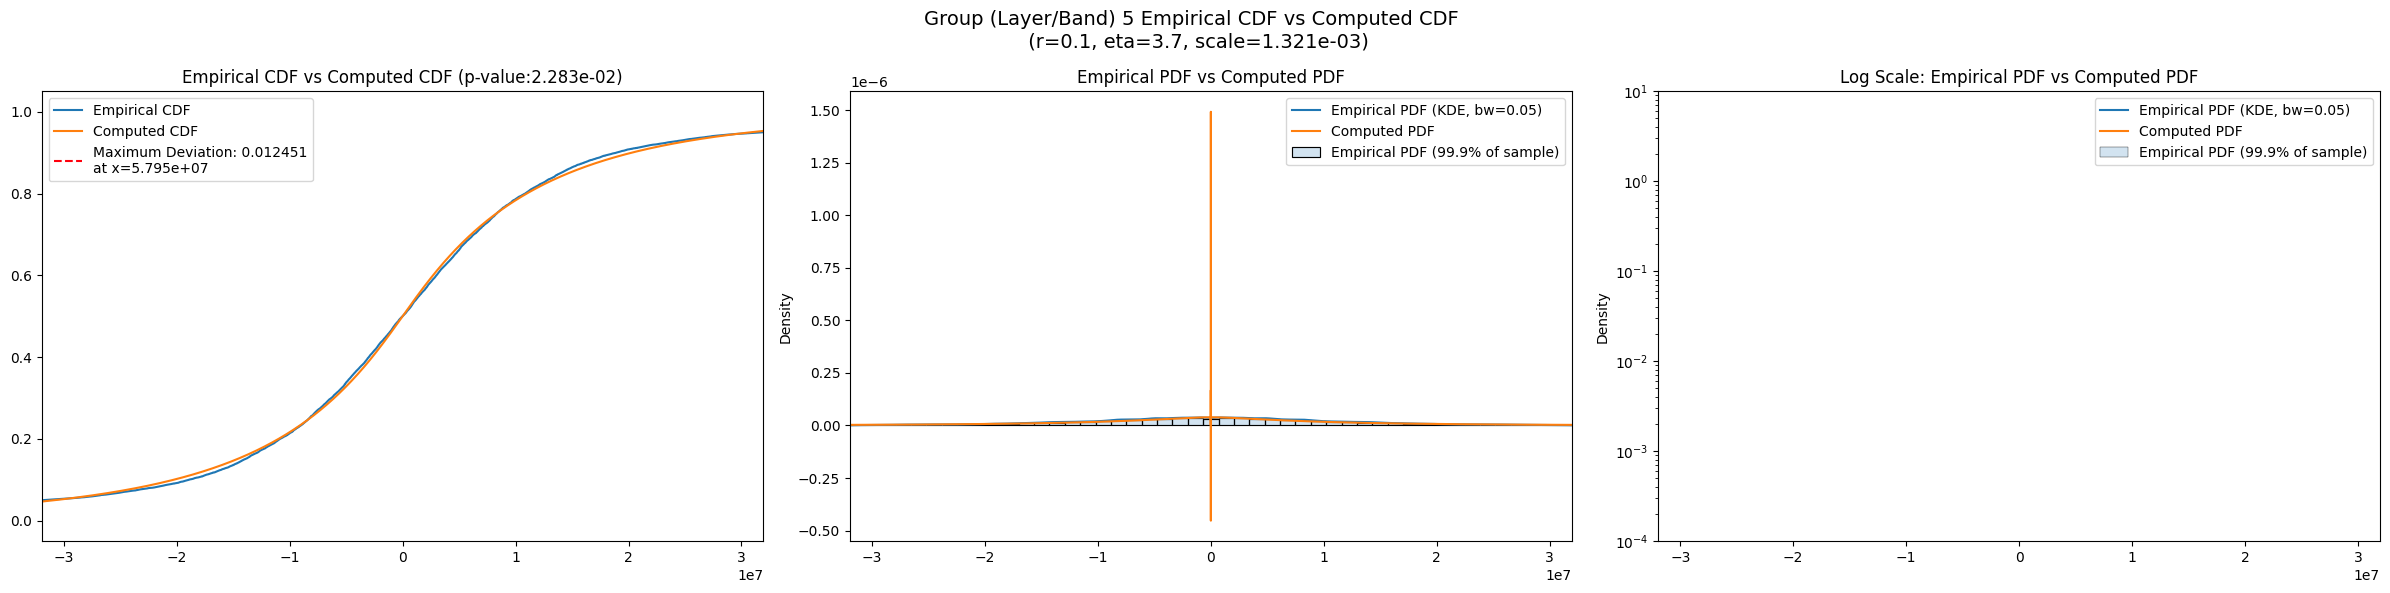

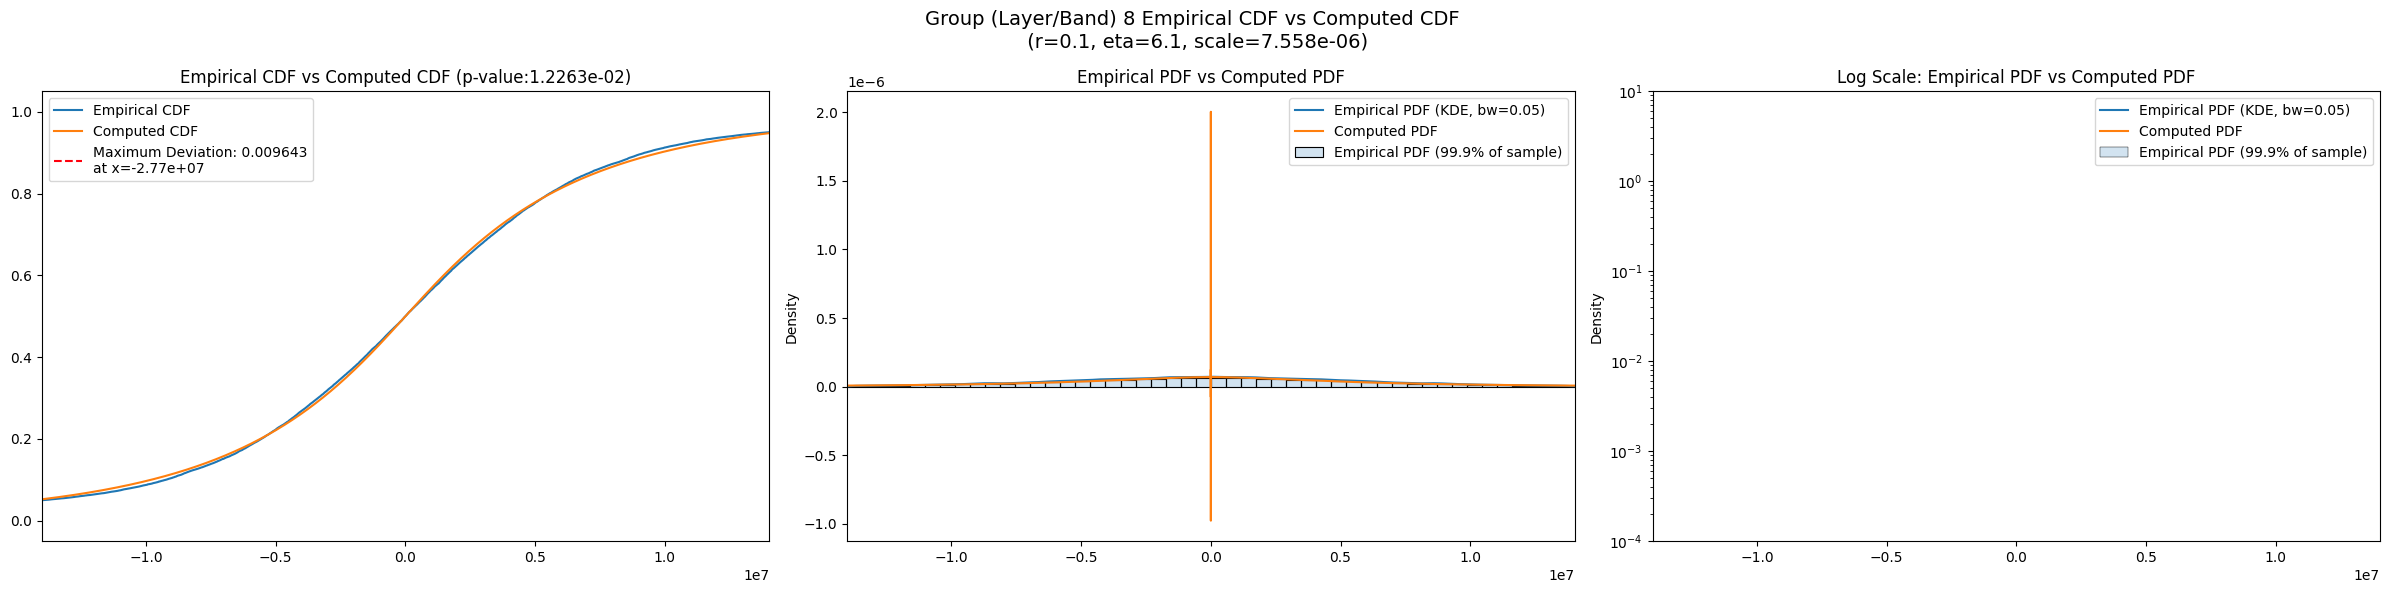

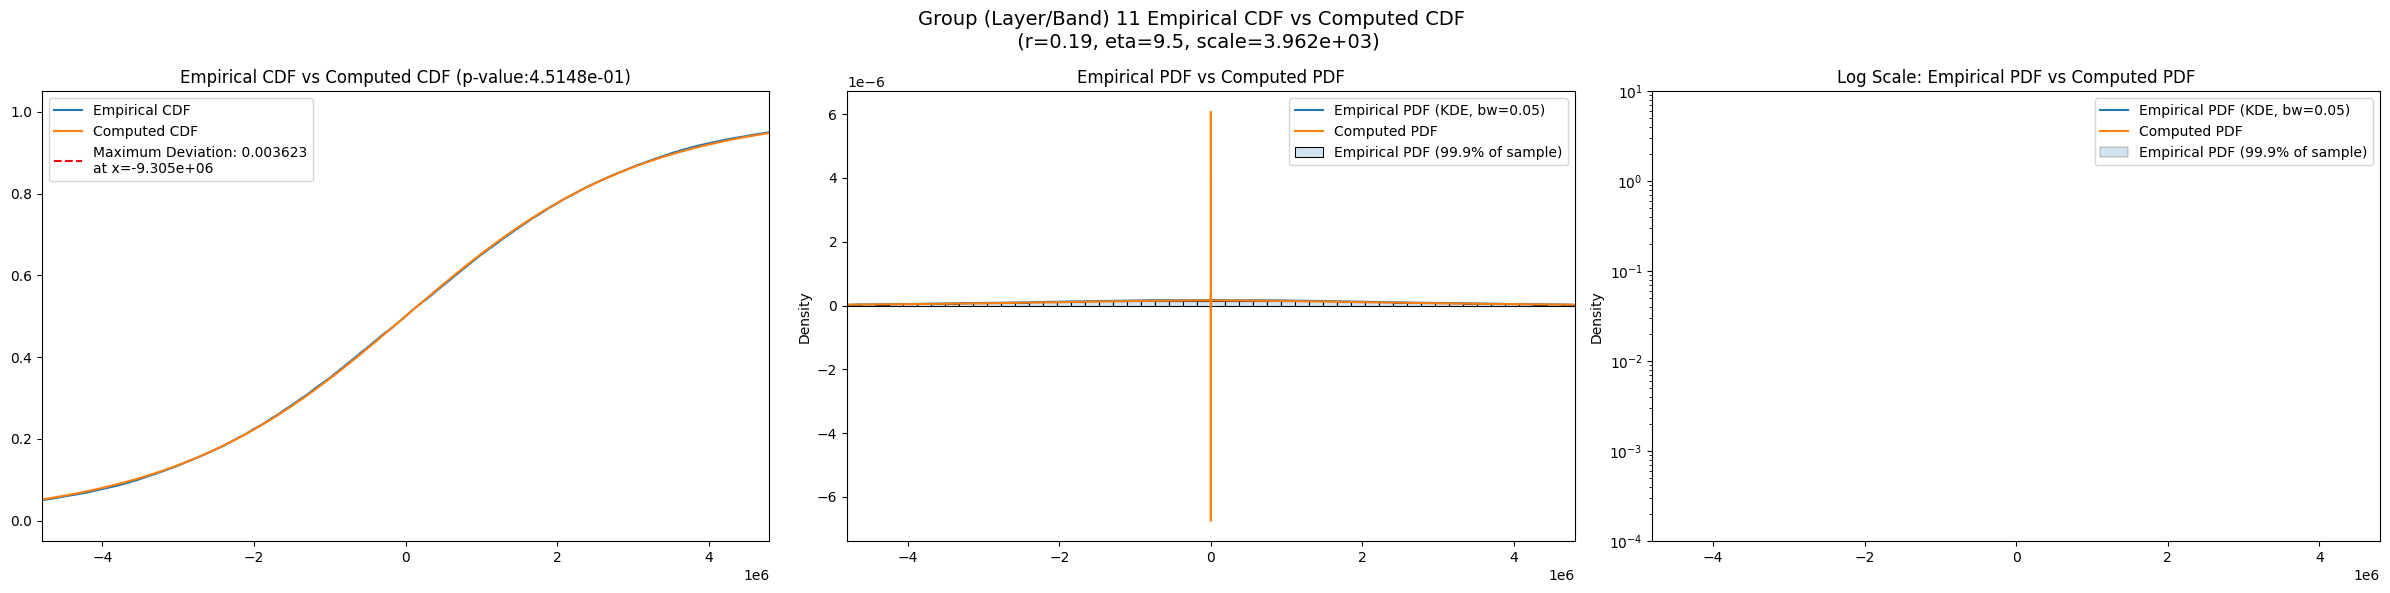

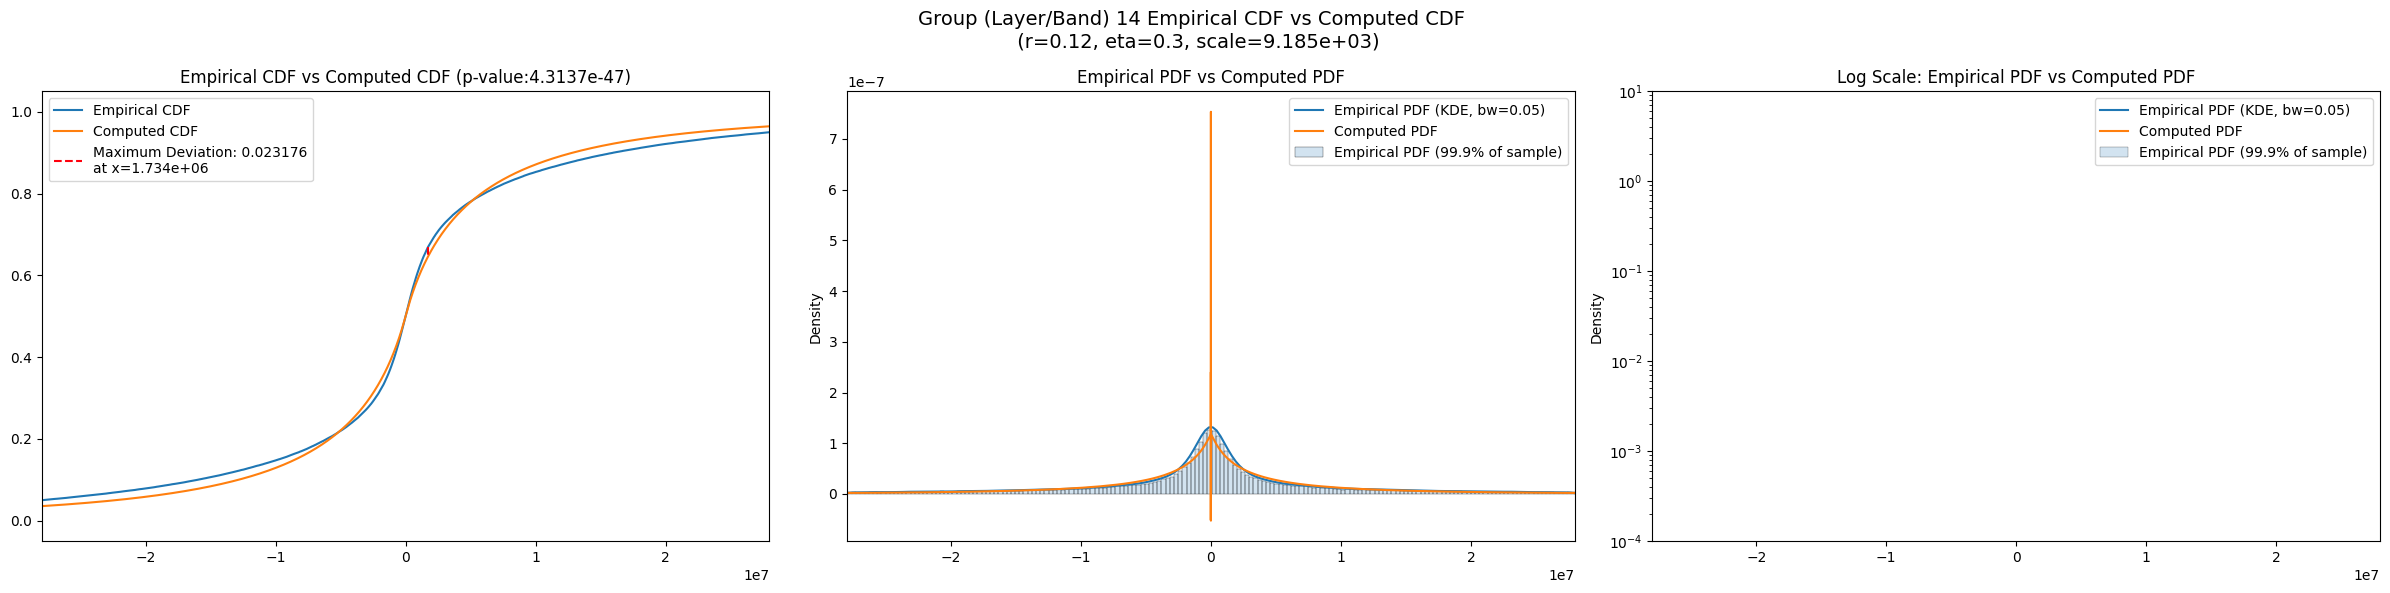

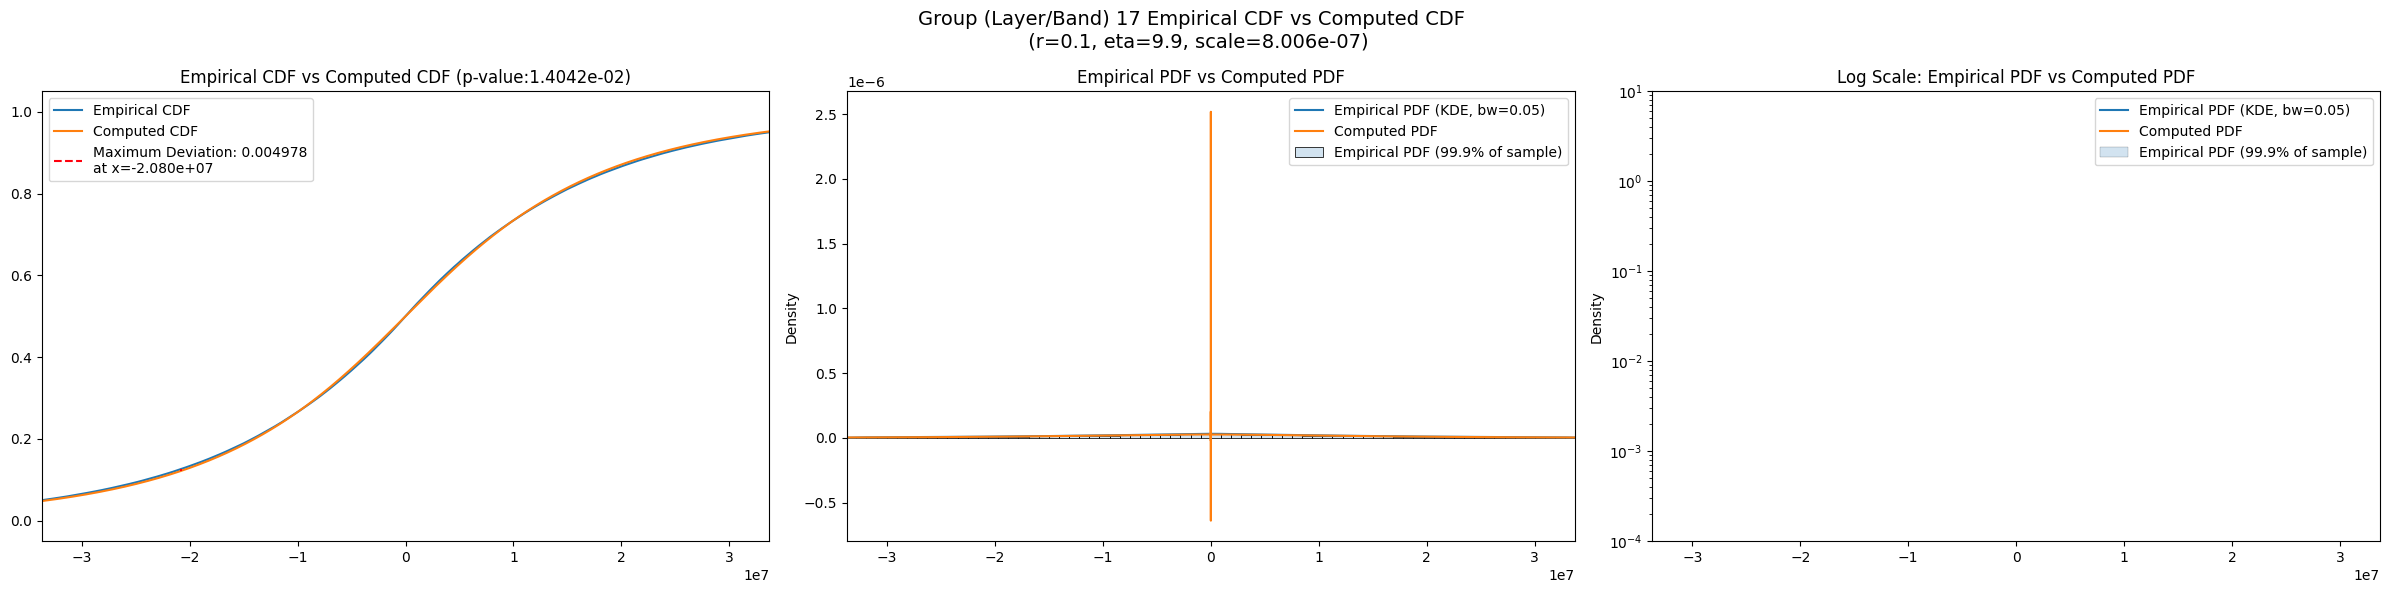

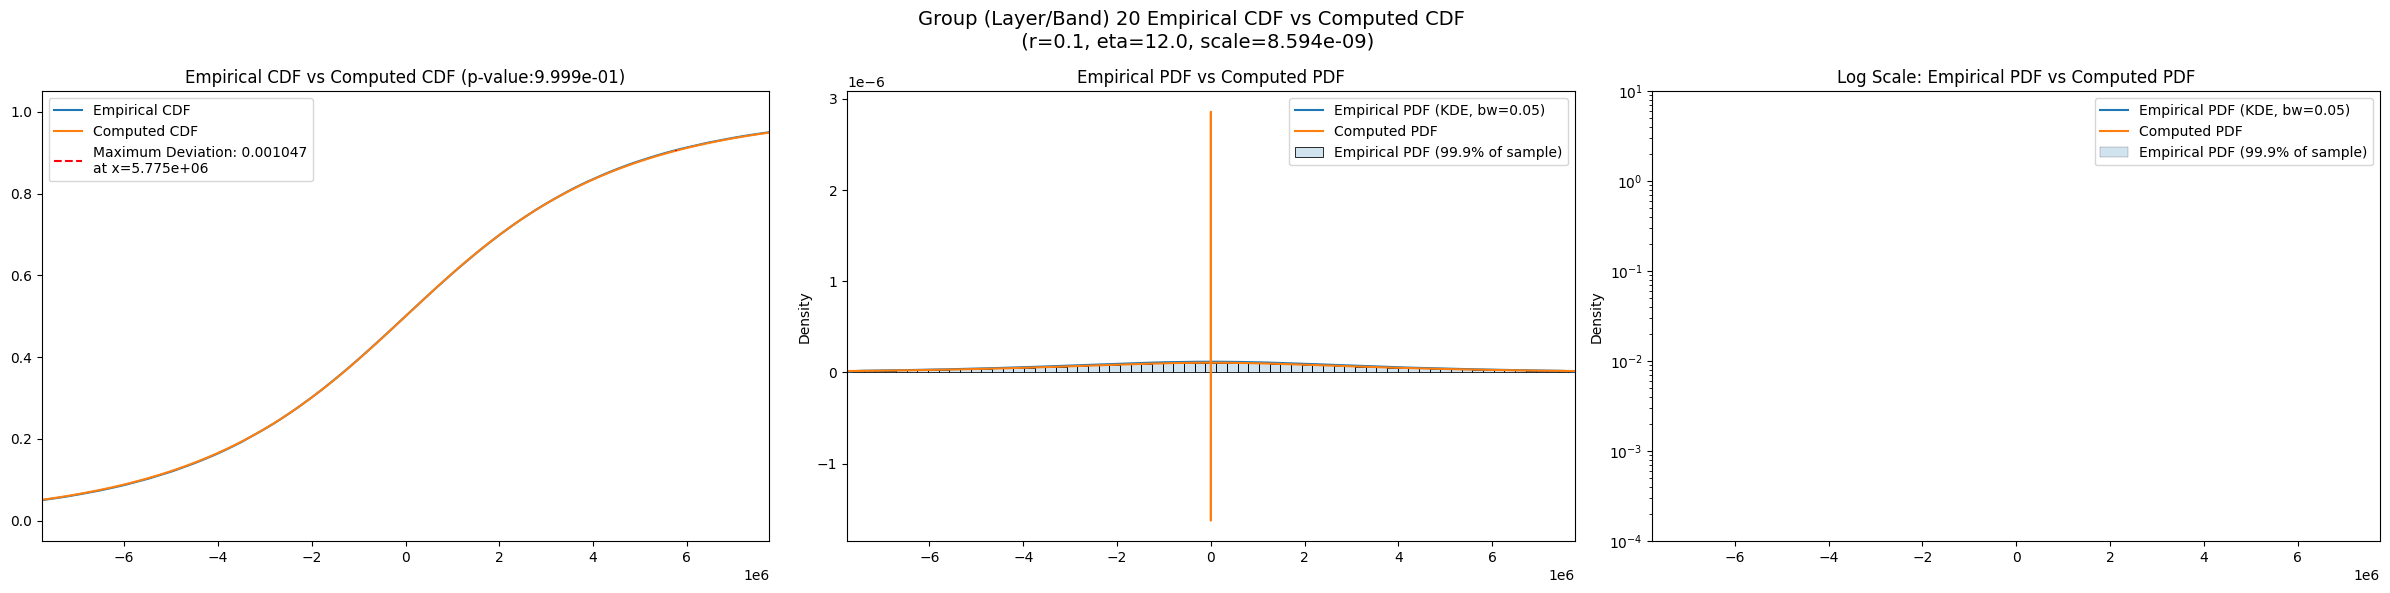

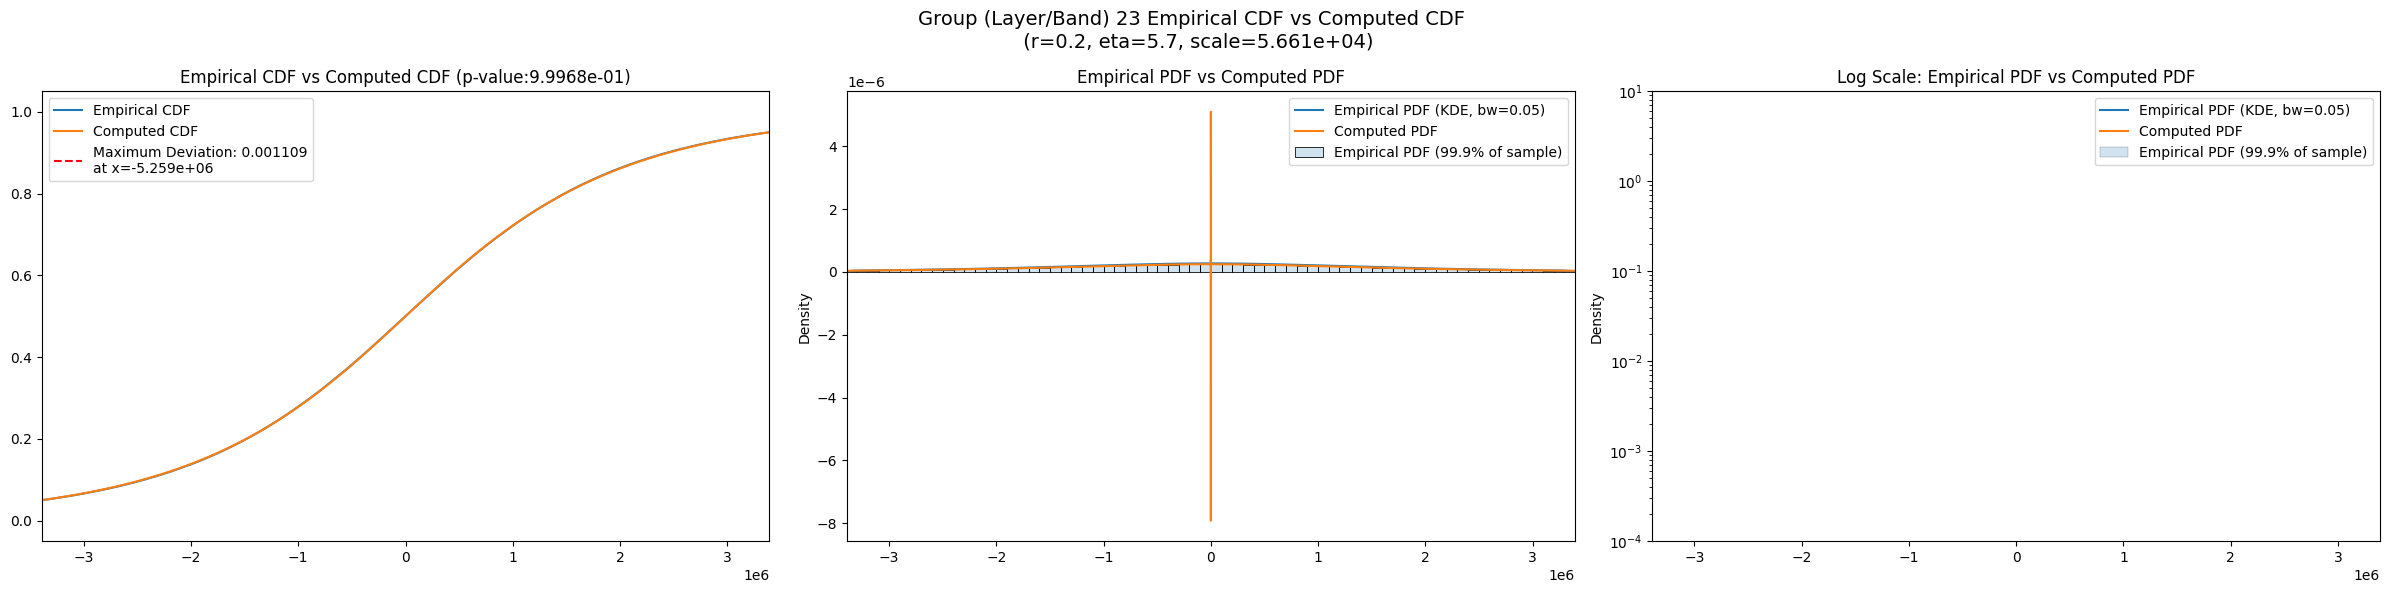

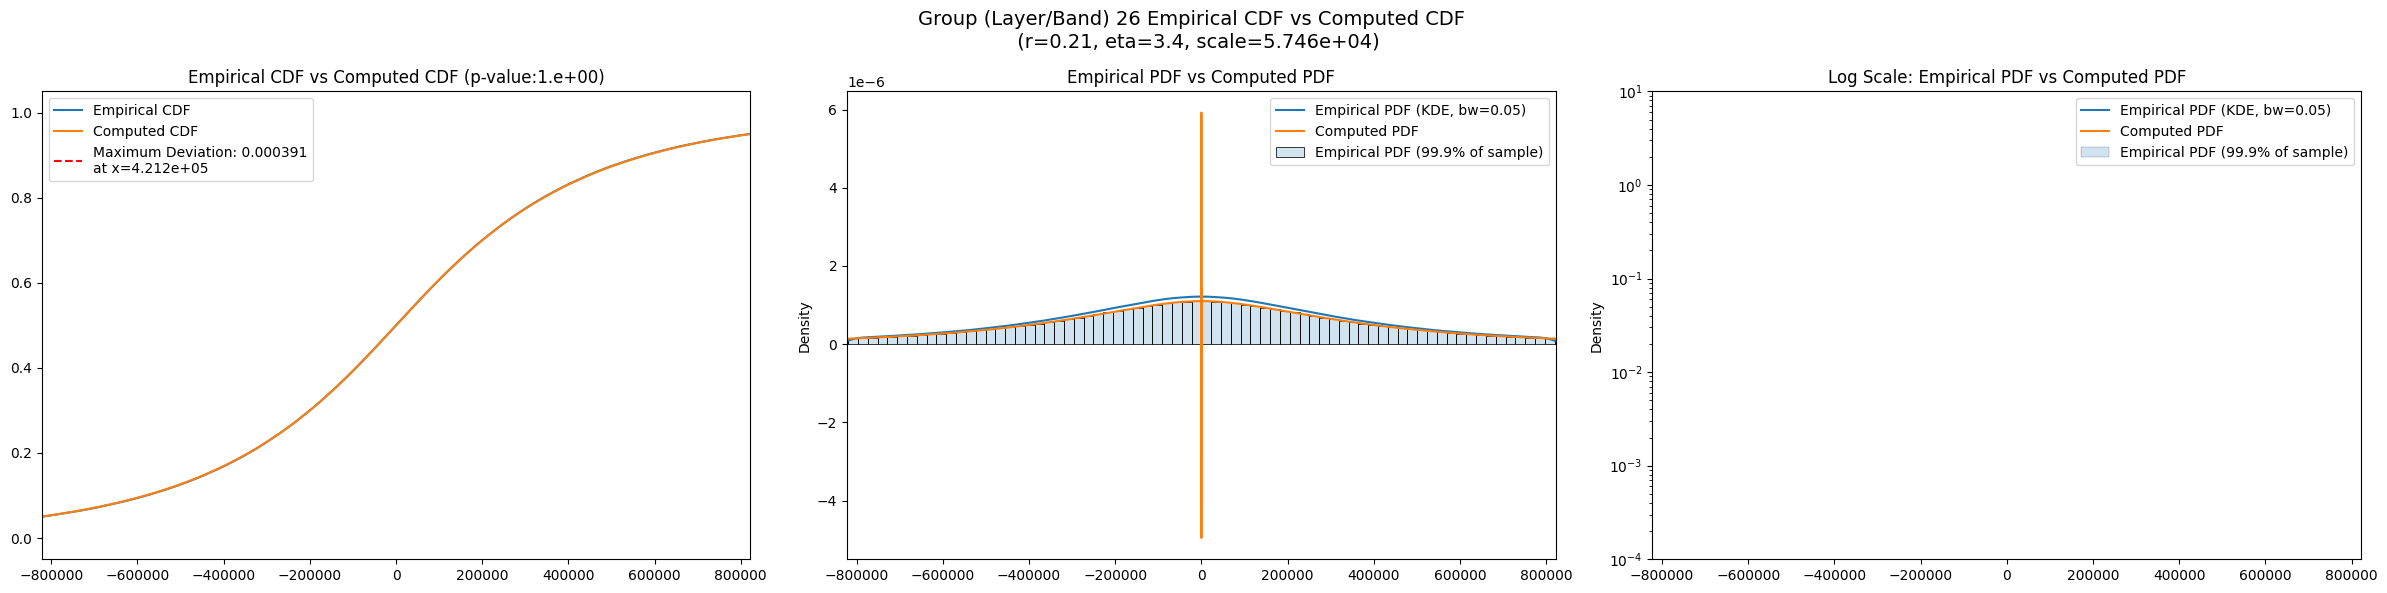

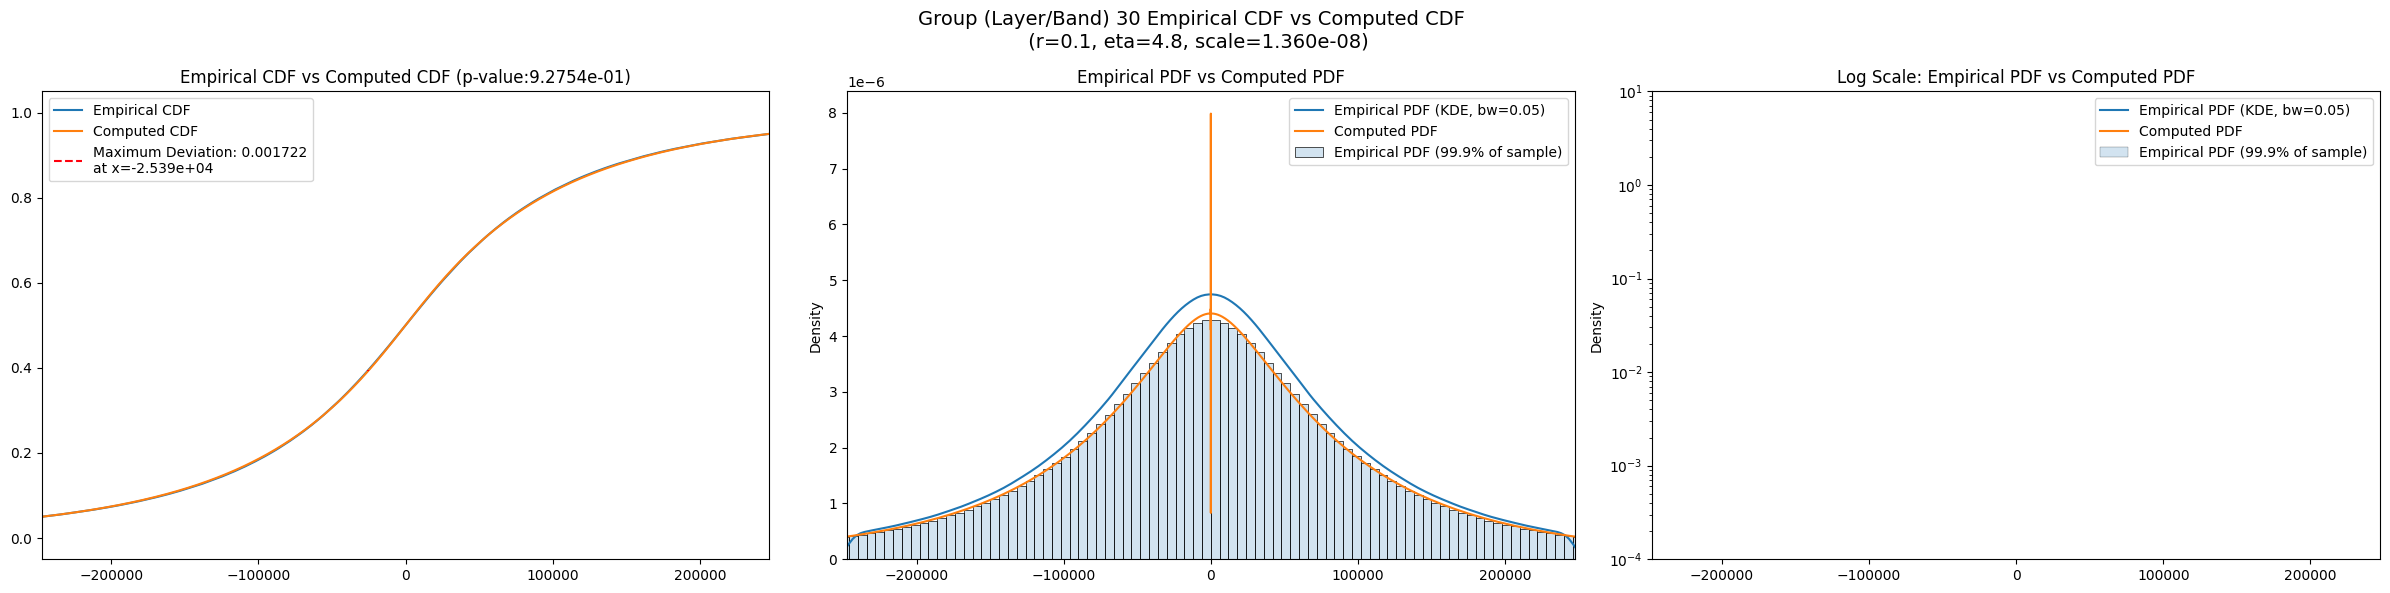

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,3.045431e+14,2.487557e+14,3.723887e+14,6.924574,2.464588,11.612601,720.0,0.012723,0.2,13.0,...,1000000.0,0.414082,2.943900e-112,1000000.0,0.378494,3.394180e-93,1000000.0,0.355794,4.581710e-82,9.997386e-01
5,7.378003e+14,6.583447e+14,8.222332e+14,16.583754,13.942364,19.255954,7200.0,0.012451,0.1,3.7,...,1000000.0,0.412971,0.000000e+00,1000000.0,0.376572,0.000000e+00,1000000.0,0.353407,0.000000e+00,2.125362e-01
8,1.589118e+14,1.382152e+14,1.825356e+14,27.638625,18.410191,41.788233,13680.0,0.010494,0.1,6.5,...,1000000.0,0.352084,0.000000e+00,1000000.0,0.308100,0.000000e+00,1000000.0,0.284112,0.000000e+00,1.560172e-01
11,1.331968e+13,1.047198e+13,1.831032e+13,131.956672,9.279535,327.704406,28080.0,0.003953,0.2,9.4,...,1000000.0,0.216524,0.000000e+00,1000000.0,0.172860,0.000000e+00,1000000.0,0.147828,0.000000e+00,8.535072e-01
14,3.351638e+14,3.051447e+14,3.680087e+14,11.289211,8.023763,15.603495,56160.0,0.023866,0.1,0.7,...,1000000.0,0.293325,0.000000e+00,1000000.0,0.251514,0.000000e+00,1000000.0,0.227675,0.000000e+00,1.231409e-26
17,4.358627e+14,4.119868e+14,4.620584e+14,2.983397,1.971252,6.272248,450720.0,0.004978,0.1,9.9,...,1000000.0,0.424720,0.000000e+00,1000000.0,0.392011,0.000000e+00,1000000.0,0.369185,0.000000e+00,3.970694e-10
20,2.468744e+13,2.310901e+13,2.647411e+13,4.895737,2.619916,11.424115,901440.0,0.001047,0.1,12.0,...,1000000.0,0.283737,0.000000e+00,1000000.0,0.236911,0.000000e+00,1000000.0,0.212666,0.000000e+00,2.758678e-01
23,4.719306e+12,4.387672e+12,5.331824e+12,11.471690,2.397953,66.410982,7211520.0,0.001109,0.2,5.7,...,1000000.0,0.131416,0.000000e+00,1000000.0,0.094966,0.000000e+00,1000000.0,0.067880,0.000000e+00,3.992596e-08
26,2.697279e+11,2.537490e+11,2.868330e+11,3.709730,2.595050,6.189963,3605760.0,0.000635,0.2,3.6,...,432924.0,0.022017,0.000000e+00,380286.0,0.008739,1.324020e-239,304993.0,0.011409,0.000000e+00,6.403962e-01


## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
band,,,,,,
2,0.012723,0.050376,0.012723,0.414082,0.378494,0.355794
5,0.012451,0.015982,0.012451,0.412971,0.376572,0.353407
8,0.010494,0.011599,0.009643,0.352084,0.308100,0.284112
11,0.003953,0.008099,0.003622,0.216524,0.172860,0.147828
14,0.023866,0.005728,0.023176,0.293325,0.251514,0.227675
17,0.004978,0.002023,0.004978,0.424720,0.392011,0.369185
20,0.001047,0.001430,0.001047,0.283737,0.236911,0.212666
23,0.001109,0.000506,0.001109,0.131416,0.094966,0.067880
26,0.000635,0.000715,0.000391,0.022017,0.008739,0.011409


In [21]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
band,,,,,,
2,3.045431e+14,0.012723,0.20,13.0,1.000000e+05,0.0
5,4.323105e+14,0.012451,0.10,3.7,1.321101e-03,100.0
8,8.582284e+13,0.009643,0.10,6.1,7.558084e-06,175.0
11,9.055233e+12,0.003622,0.19,9.5,3.961983e+03,125.0
14,3.351638e+14,0.023176,0.12,0.3,9.185283e+03,0.0
17,4.358627e+14,0.004978,0.10,9.9,8.006498e-07,0.0
20,2.393368e+13,0.001047,0.10,12.0,8.593862e-09,25.0
23,4.469951e+12,0.001109,0.20,5.7,5.660963e+04,50.0
26,2.697279e+11,0.000391,0.21,3.4,5.745964e+04,0.0
